# <center> Rain Prediction </center>

# Table of Contents:
* ## [Introduction](#introduction)

* ## [Cleaning the Data:](#clean)
    - ### [Dealing with Null Values](#null)
    - ### [Preprocessing the Data](#preprocess)
    - ### [Dealing with Imbalance](#imbalance)

* ## [Modeling:](#model)
    - ### [Random Forest](#forest)
    - ### [Logistic Regression](#log)
    - ### [XGBoost](#xgb)
    - ### [CatBoost](#cat)

* ## [More Experiments:](#experiments)
    - ### [Label Encoding](#label)
    - ### [No Scaling](#scaling)
    - ### [Feature Engineering](#engineering)

* ## [Final Model](#final)

## Introduction: <a class="anchor" id="introduction"></a>

<b> This is the main notebook for the rain prediction project. The goal of the project is to predict whether it will rain or not tomorrow based on weather data. The data of the project which is used to train the models is the [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) dataset taken from Kaggle </b>

### Importing necessarry libraries

In [78]:
from sklearn import preprocessing, metrics
import scipy.stats as stats
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler 
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesRegressor
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style="whitegrid")
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import pickle as pkl

# Cleaning the Data <a class="anchor" id="clean"></a>

In [2]:
df = pd.read_csv("data/weatherAUS.csv")
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


## Dealing with Null values <a class="anchor" id="null"></a>

In [3]:
df.isnull().sum().sort_values(ascending = False)

Sunshine         69835
Evaporation      62790
Cloud3pm         59358
Cloud9am         55888
Pressure9am      15065
Pressure3pm      15028
WindDir9am       10566
WindGustDir      10326
WindGustSpeed    10263
Humidity3pm       4507
WindDir3pm        4228
Temp3pm           3609
RainTomorrow      3267
Rainfall          3261
RainToday         3261
WindSpeed3pm      3062
Humidity9am       2654
Temp9am           1767
WindSpeed9am      1767
MinTemp           1485
MaxTemp           1261
Location             0
Date                 0
dtype: int64

In [4]:
df.shape[0] - df.dropna().shape[0]           

89040

**So, we lose 89,040 rows out of 145,460 rows if we decide to drop null values, i.e. ~60% of the data!**

#### Therefore, instead, we'll drop the top 4 columns in terms of null values, then drop null values of remaining columns

In [5]:
df.drop(["Sunshine", "Evaporation", "Cloud3pm", "Cloud9am"], axis = 1, inplace = True)

In [6]:
df.dropna(how = 'any', inplace = True)

In [7]:
df.shape

(112925, 19)

#### Therefore, by doing so, we're only losing ~20% of data instead of ~60%. The remaining rows are 112,925 out of 142,460.

## Preprocessing the Data <a class="anchor" id="preprocess"></a>

In [8]:
numerical = list(df._get_numeric_data().columns)
categorical = list(set(df.columns) - set(numerical))
print("Numerical Features: \n", list(numerical))
print("\n Categorical Features: \n", categorical)

Numerical Features: 
 ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

 Categorical Features: 
 ['Date', 'Location', 'WindDir3pm', 'RainTomorrow', 'WindGustDir', 'RainToday', 'WindDir9am']


### Numerical Features

#### Outliers

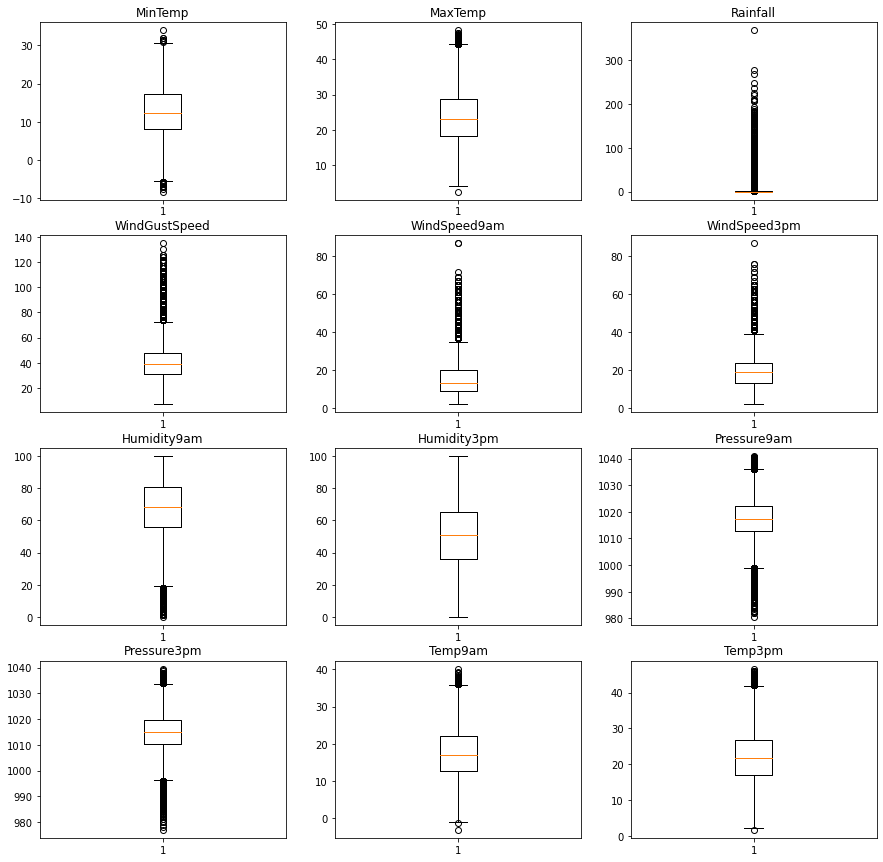

In [9]:
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(df[numerical[k]])
        axis[i,j].set_title(numerical[k])
        k += 1

In [10]:
df.shape

(112925, 19)

In [11]:
for n in numerical:
    q1 = df[n].quantile(0.25)
    q3 = df[n].quantile(0.75)
    IQR = q3 - q1
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR
    df.loc[(df[n] <= lower), n] = lower
    df.loc[(df[n] >= upper), n] = upper  

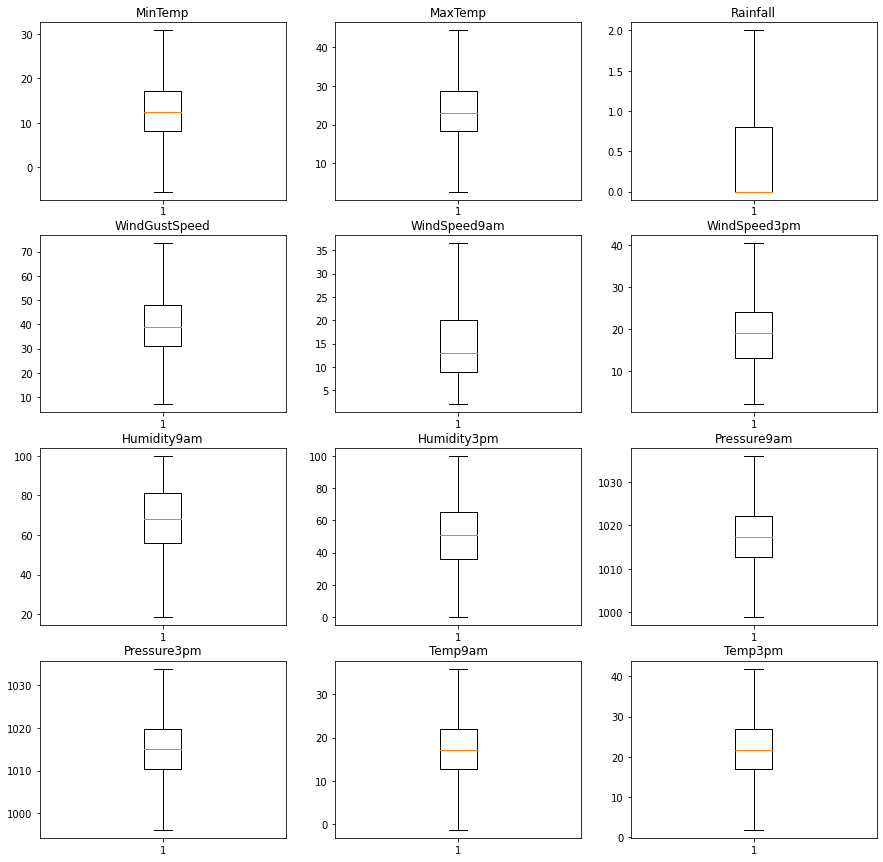

In [12]:
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(df[numerical[k]])
        axis[i,j].set_title(numerical[k])
        k += 1

In [13]:
df.shape

(112925, 19)

### Categorical Features

In [14]:
categorical

['Date',
 'Location',
 'WindDir3pm',
 'RainTomorrow',
 'WindGustDir',
 'RainToday',
 'WindDir9am']

In [15]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No,No
145455,2017-06-21,Uluru,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No


#### Wind

In [16]:
df = pd.get_dummies(df, columns = ["WindGustDir", "WindDir9am", "WindDir3pm"], drop_first = True)
df.shape

(112925, 61)

#### Rain Today / Tomorrow

In [17]:
df["RainToday"] = pd.get_dummies(df["RainToday"], drop_first = True)
df["RainTomorrow"] = pd.get_dummies(df["RainTomorrow"], drop_first = True)

#### Date / Location

In [18]:
df.drop(["Date", "Location"], axis = 1, inplace = True)

In [19]:
df.shape

(112925, 59)

### Scaling

In [20]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0.520604,0.485577,0.3,0.556391,0.521739,0.571429,0.644172,0.22,0.237903,0.289894,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.355769,0.538462,0.0,0.556391,0.057971,0.519481,0.312883,0.25,0.315860,0.308511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.506868,0.552885,0.0,0.586466,0.492754,0.623377,0.239264,0.30,0.235215,0.332447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.405220,0.608173,0.0,0.255639,0.260870,0.181818,0.325153,0.16,0.504032,0.441489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.633242,0.711538,0.5,0.511278,0.144928,0.467532,0.779141,0.33,0.321237,0.260638,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Correlation

<AxesSubplot:>

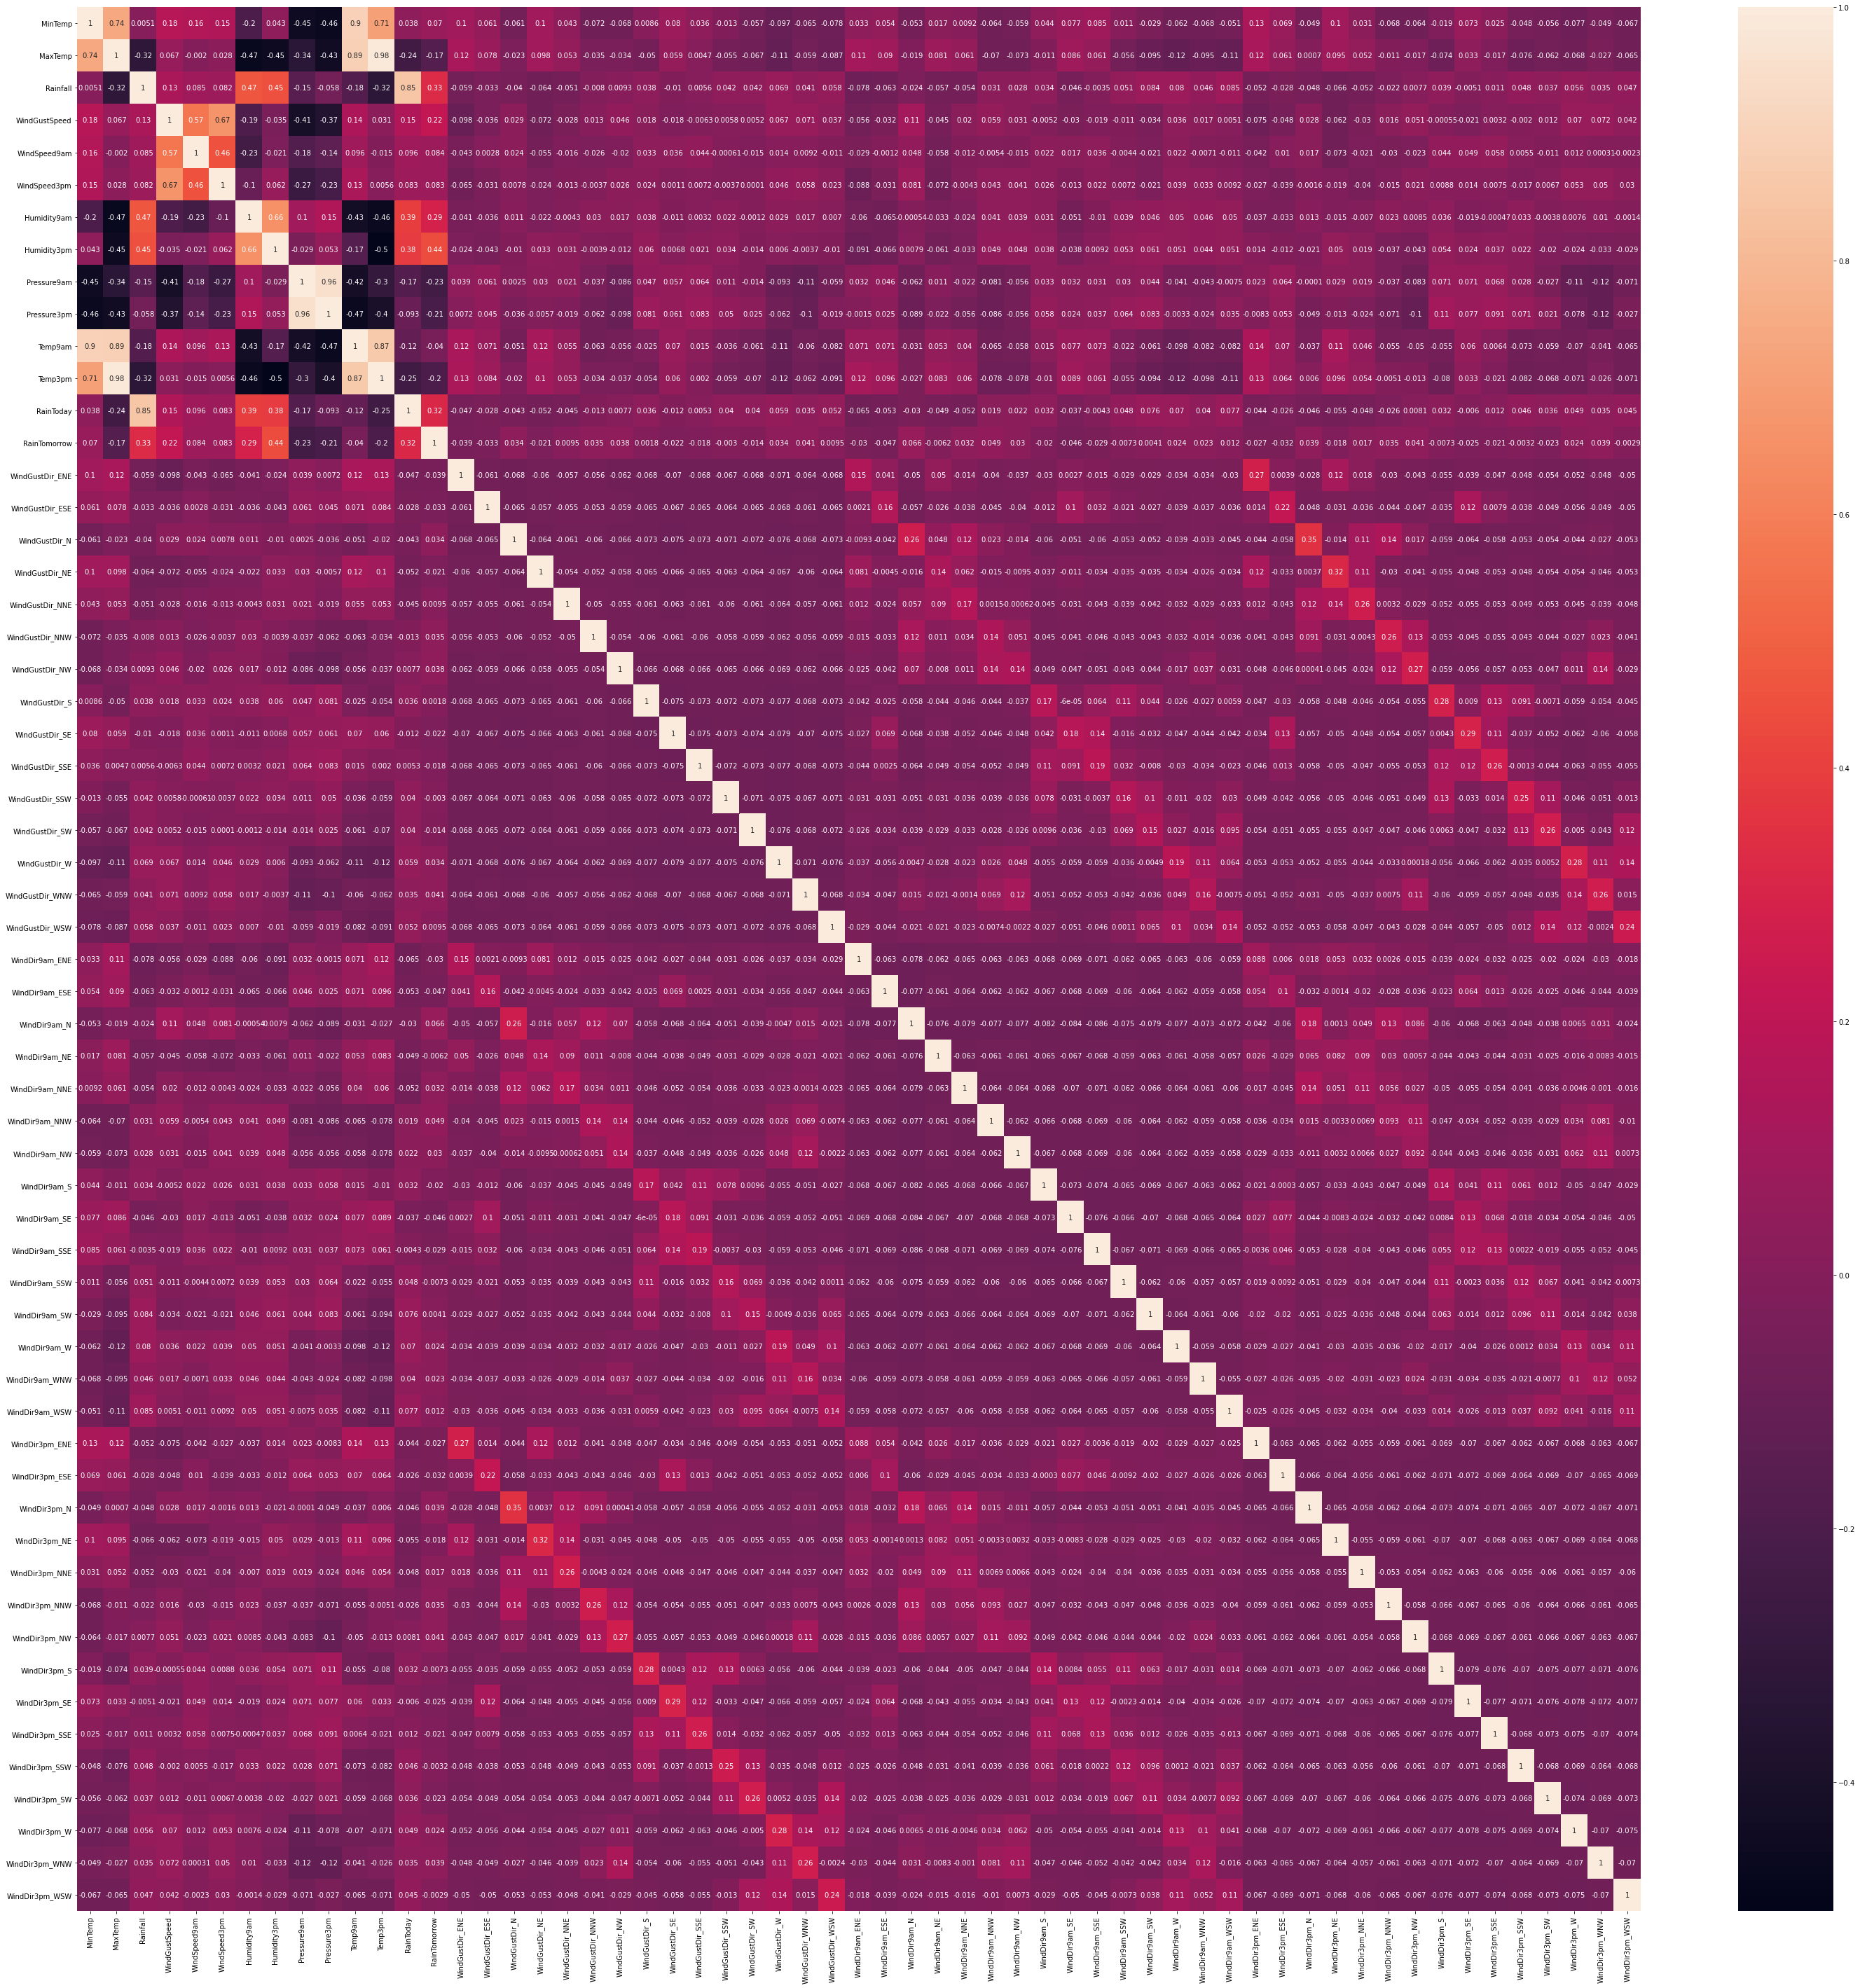

In [21]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(50,50))
sns.heatmap(corrmat,annot=True)

### Feature Importance

<ipython-input-22-4cbe2d20b817>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  selection.fit(X,y)


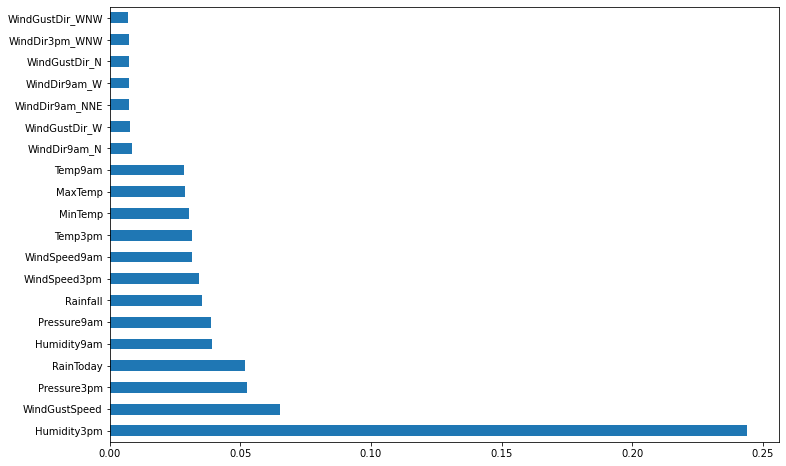

In [22]:
### Feature Importance
X = df.loc[:,df.columns!='RainTomorrow']
y = df[['RainTomorrow']]

selection =ExtraTreesRegressor()
selection.fit(X,y)
selection.feature_importances_

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_,index = X.columns)
feat_importances.nlargest(20).plot(kind="barh")
plt.show()


### Splitting the Data

In [23]:
X = df.loc[:,df.columns!='RainTomorrow']
y = df[['RainTomorrow']]

X_train_or, X_test, y_train_or, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size=0.25)

X_val_OG = X_val.copy()
y_val_OG = y_val.copy()
X_test_OG = X_test.copy()
y_test_OG = y_test.copy()

## Dealing with Imbalance <a class="anchor" id="imbalance"></a>

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

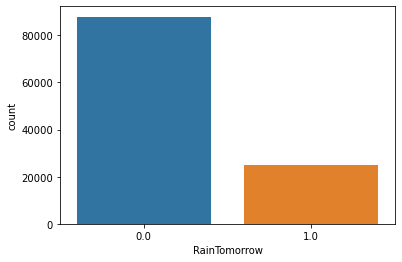

In [24]:
sns.countplot(x = df["RainTomorrow"])

### SMOTE

The total observations before: 67755
The total observations after: 105478


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

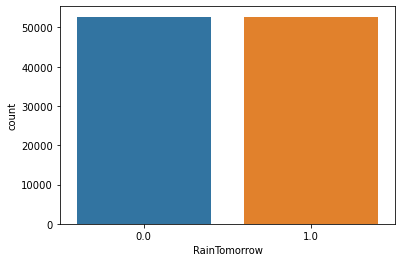

In [25]:
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("The total observations before:", len(y_train.index))
print("The total observations after:", len(y_train_res.index))

sns.countplot(x = y_train_res["RainTomorrow"])

### ADASYN

The total observations before: 67755
The total observations after: 106685


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

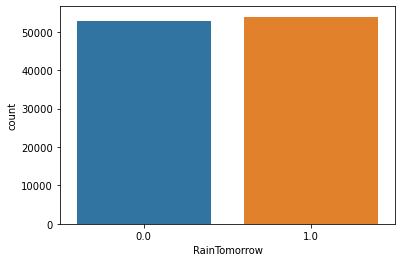

In [26]:
ada = ADASYN()
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

X_train_OG = X_train_ada.copy()
y_train_OG = y_train_ada.copy()

print("The total observations before:", len(y_train.index))
print("The total observations after:", len(y_train_ada.index))

sns.countplot(x = y_train_ada["RainTomorrow"])

### Random Oversampling

The number of classes before: 67755
The total observations after: 105478


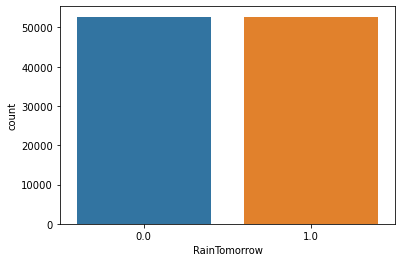

In [27]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

print("The number of classes before:", len(y_train.index))
print("The total observations after:", len(y_train_over.index))

sns.countplot(x = y_train_over["RainTomorrow"]);

# Modeling <a class="anchor" id="model"></a>

## Random Forest <a class="anchor" id="forest"></a>

In [28]:
# rf = RandomForestClassifier(random_state=0)
# parameters = {'bootstrap': [True, False],
#               'min_samples_split':[2, 3, 4],
#               'criterion':['entropy', 'gini'],
#               'n_estimators':[100, 200]
#              }
# grid_search = GridSearchCV(estimator=rf, param_grid=parameters, refit='roc_auc', scoring=['accuracy', 'roc_auc'], cv=10, n_jobs=-1)
# grid_search = grid_search.fit(Xtrain, ytrain.values.ravel())

GridSearchCV takes a long time and the best parameters are similar to the default so it's not necessarry.

### Random Forest - Imbalanced

<ipython-input-29-0b820eb9fb21>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     17534
         1.0       0.77      0.49      0.60      5051

    accuracy                           0.85     22585
   macro avg       0.82      0.73      0.76     22585
weighted avg       0.85      0.85      0.84     22585



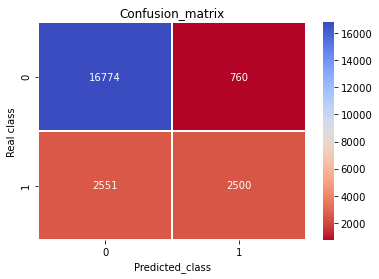

0.7258035676117292

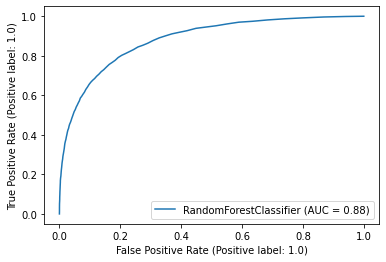

In [29]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred10 = rf.predict(X_val)
print(classification_report(y_val,y_pred10))

cnf_matrix = confusion_matrix(y_val, y_pred10)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5,fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(rf, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred10, average=None) 

### Random Forest - SMOTE

<ipython-input-30-f655d6eff9d3>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_res, y_train_res)


              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     17534
         1.0       0.64      0.68      0.66      5051

    accuracy                           0.84     22585
   macro avg       0.77      0.78      0.78     22585
weighted avg       0.85      0.84      0.84     22585



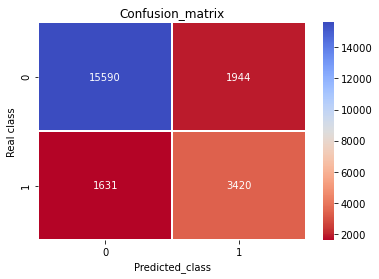

0.7831116678545427

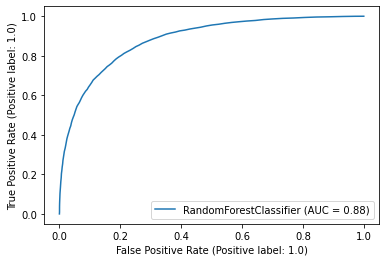

In [30]:
rf=RandomForestClassifier()
rf.fit(X_train_res, y_train_res)

y_pred11 = rf.predict(X_val)
print(classification_report(y_val,y_pred11))

cnf_matrix = confusion_matrix(y_val, y_pred11)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5,fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(rf, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred11, average=None) 

### Random Forest - ADA

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89     17534
         1.0       0.63      0.70      0.66      5051

    accuracy                           0.84     22585
   macro avg       0.77      0.79      0.78     22585
weighted avg       0.85      0.84      0.84     22585



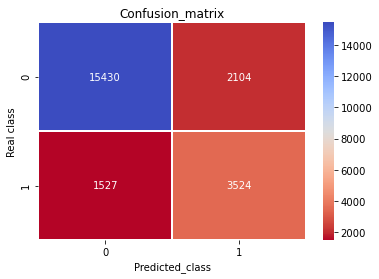

0.7888440947843574

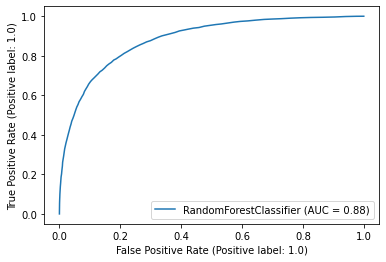

In [31]:
rf=RandomForestClassifier()
rf.fit(X_train_ada, y_train_ada.values.ravel())

y_pred12 = rf.predict(X_val)
print(classification_report(y_val,y_pred12))

cnf_matrix = confusion_matrix(y_val, y_pred12)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5,fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(rf, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred12, average=None) 

### Random Forest - RandomOverSampling

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     17534
         1.0       0.71      0.58      0.64      5051

    accuracy                           0.85     22585
   macro avg       0.80      0.76      0.77     22585
weighted avg       0.85      0.85      0.85     22585



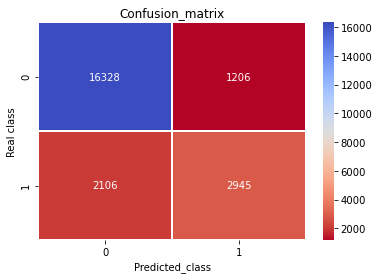

0.7571361030458413

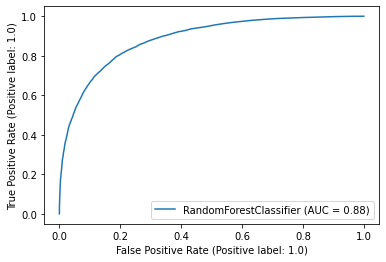

In [32]:
rf=RandomForestClassifier()
rf.fit(X_train_over, y_train_over.values.ravel())

y_pred13 = rf.predict(X_val)
print(classification_report(y_val,y_pred13))

cnf_matrix = confusion_matrix(y_val, y_pred13)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5,fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(rf, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred13, average=None) 

## Logistic Regression <a class="anchor" id="log"></a>

### Logistic Regression - Imbalanced

0.84941332742971
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     17534
         1.0       0.74      0.51      0.60      5051

    accuracy                           0.85     22585
   macro avg       0.80      0.73      0.75     22585
weighted avg       0.84      0.85      0.84     22585



C:\Users\Meshal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


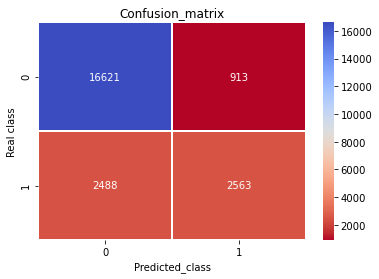

0.7276770044666112

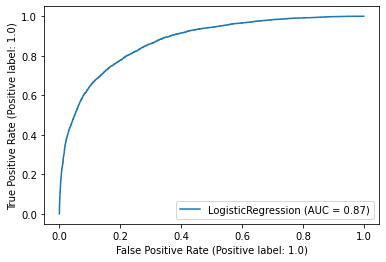

In [33]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())

y_pred20 = logreg.predict(X_val)
print(accuracy_score(y_val,y_pred20))
print(classification_report(y_val,y_pred20))

cnf_matrix = confusion_matrix(y_val, y_pred20)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(logreg, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred20, average=None)

### Logistic Regression - SMOTE

              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86     17534
         1.0       0.54      0.77      0.63      5051

    accuracy                           0.80     22585
   macro avg       0.73      0.79      0.75     22585
weighted avg       0.84      0.80      0.81     22585



C:\Users\Meshal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


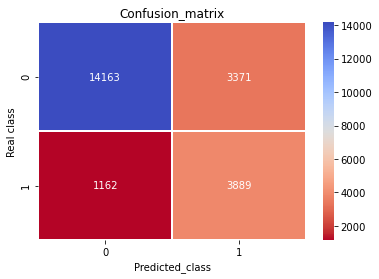

0.7888457489509818

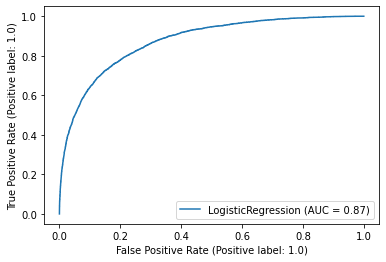

In [34]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res.values.ravel())

y_pred21 = logreg.predict(X_val)
print(classification_report(y_val,y_pred21))

cnf_matrix = confusion_matrix(y_val, y_pred21)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(logreg, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred21, average=None)

### Logistic Regression - ADA

              precision    recall  f1-score   support

         0.0       0.93      0.78      0.85     17534
         1.0       0.51      0.79      0.62      5051

    accuracy                           0.79     22585
   macro avg       0.72      0.79      0.74     22585
weighted avg       0.84      0.79      0.80     22585



C:\Users\Meshal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


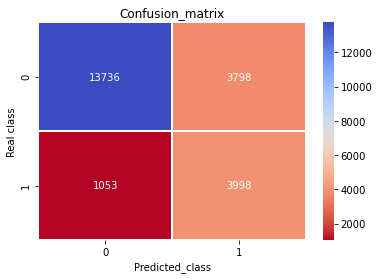

0.7874593484317836

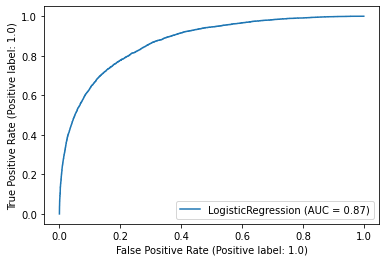

In [35]:
logreg = LogisticRegression()
logreg.fit(X_train_ada, y_train_ada.values.ravel())

y_pred22 = logreg.predict(X_val)
print(classification_report(y_val,y_pred22))

cnf_matrix = confusion_matrix(y_val, y_pred22)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(logreg, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred22, average=None)

### Logistic Regression - RandomOverSampling

              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86     17534
         1.0       0.53      0.78      0.63      5051

    accuracy                           0.80     22585
   macro avg       0.73      0.79      0.75     22585
weighted avg       0.84      0.80      0.81     22585



C:\Users\Meshal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


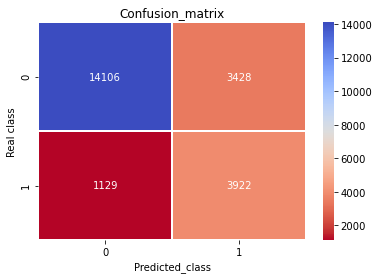

0.7904870153339778

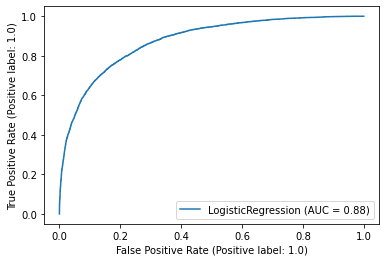

In [36]:
logreg = LogisticRegression()
logreg.fit(X_train_over, y_train_over.values.ravel())

y_pred23 = logreg.predict(X_val)
print(classification_report(y_val,y_pred23))

cnf_matrix = confusion_matrix(y_val, y_pred23)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(logreg, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred23, average=None)

## XGBoost <a class="anchor" id="xgb"></a>

### XGBoost - Imbalanced

In [37]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train, y_train)

[17:33:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     17534
         1.0       0.74      0.54      0.62      5051

    accuracy                           0.85     22585
   macro avg       0.81      0.74      0.77     22585
weighted avg       0.85      0.85      0.85     22585



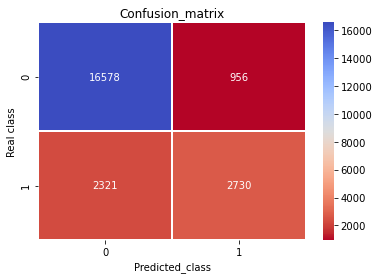

0.7429821952730941

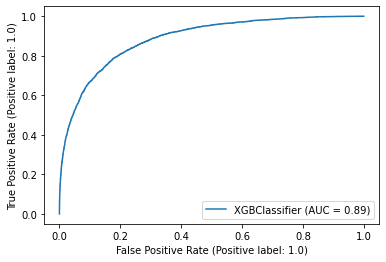

In [38]:
y_pred30 = xgb.predict(X_val)
print(classification_report(y_val,y_pred30))

cnf_matrix = confusion_matrix(y_val, y_pred30)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(xgb, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred30, average=None)

### XGBoost - SMOTE

In [39]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train_res, y_train_res)

[17:33:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     17534
         1.0       0.72      0.57      0.63      5051

    accuracy                           0.85     22585
   macro avg       0.80      0.75      0.77     22585
weighted avg       0.85      0.85      0.85     22585



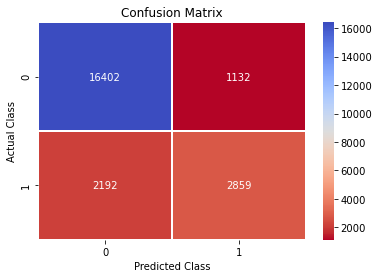

0.7507331232605704

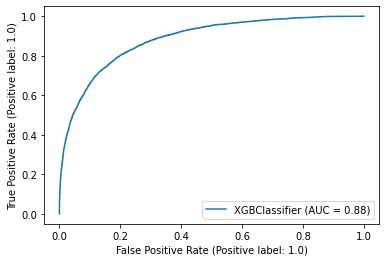

In [40]:
y_pred31 = xgb.predict(X_val)
print(classification_report(y_val,y_pred31))

cnf_matrix = confusion_matrix(y_val, y_pred31)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(xgb, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred31, average=None)

### XGBoost - ADA

In [41]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train_ada, y_train_ada)

[17:33:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     17534
         1.0       0.72      0.57      0.63      5051

    accuracy                           0.85     22585
   macro avg       0.80      0.75      0.77     22585
weighted avg       0.85      0.85      0.85     22585



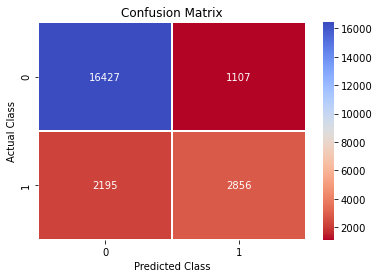

0.7511490530138837

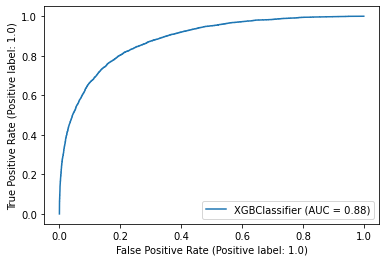

In [42]:
y_pred32 = xgb.predict(X_val)
print(classification_report(y_val,y_pred32))

cnf_matrix = confusion_matrix(y_val, y_pred32)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(xgb, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred32, average=None)

### XGBoost - RandomOverSampling

In [43]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train_over, y_train_over)

[17:33:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88     17534
         1.0       0.58      0.75      0.65      5051

    accuracy                           0.82     22585
   macro avg       0.75      0.80      0.77     22585
weighted avg       0.84      0.82      0.83     22585



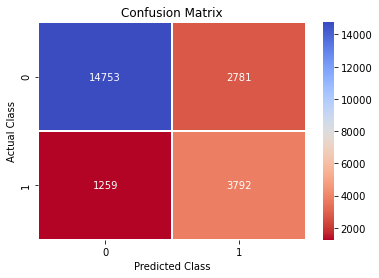

0.7960681452966668

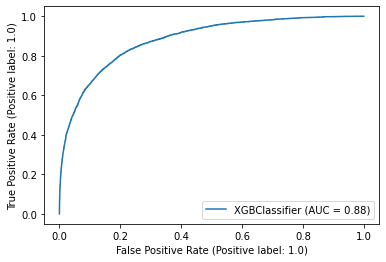

In [44]:
y_pred33 = xgb.predict(X_val)
print(classification_report(y_val,y_pred33))

cnf_matrix = confusion_matrix(y_val, y_pred33)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(xgb, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred33, average=None)

## CatBoost <a class="anchor" id="cat"></a>

### CatBoost - Imbalanced

In [45]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train, y_train)

Learning rate set to 0.033014
0:	total: 138ms	remaining: 4m 35s
1:	total: 143ms	remaining: 2m 22s
2:	total: 148ms	remaining: 1m 38s
3:	total: 153ms	remaining: 1m 16s
4:	total: 158ms	remaining: 1m 3s
5:	total: 163ms	remaining: 54.2s
6:	total: 168ms	remaining: 47.9s
7:	total: 174ms	remaining: 43.2s
8:	total: 179ms	remaining: 39.6s
9:	total: 184ms	remaining: 36.7s
10:	total: 190ms	remaining: 34.3s
11:	total: 195ms	remaining: 32.3s
12:	total: 200ms	remaining: 30.6s
13:	total: 205ms	remaining: 29.1s
14:	total: 211ms	remaining: 27.9s
15:	total: 217ms	remaining: 26.9s
16:	total: 222ms	remaining: 25.9s
17:	total: 228ms	remaining: 25.1s
18:	total: 233ms	remaining: 24.3s
19:	total: 238ms	remaining: 23.6s
20:	total: 244ms	remaining: 23s
21:	total: 249ms	remaining: 22.4s
22:	total: 254ms	remaining: 21.9s
23:	total: 259ms	remaining: 21.3s
24:	total: 264ms	remaining: 20.8s
25:	total: 268ms	remaining: 20.4s
26:	total: 274ms	remaining: 20s
27:	total: 279ms	remaining: 19.6s
28:	total: 284ms	remaining: 

257:	total: 1.48s	remaining: 9.99s
258:	total: 1.48s	remaining: 9.98s
259:	total: 1.49s	remaining: 9.97s
260:	total: 1.49s	remaining: 9.96s
261:	total: 1.5s	remaining: 9.95s
262:	total: 1.5s	remaining: 9.94s
263:	total: 1.51s	remaining: 9.93s
264:	total: 1.51s	remaining: 9.92s
265:	total: 1.52s	remaining: 9.91s
266:	total: 1.53s	remaining: 9.91s
267:	total: 1.53s	remaining: 9.91s
268:	total: 1.54s	remaining: 9.9s
269:	total: 1.54s	remaining: 9.89s
270:	total: 1.55s	remaining: 9.88s
271:	total: 1.55s	remaining: 9.87s
272:	total: 1.56s	remaining: 9.86s
273:	total: 1.56s	remaining: 9.85s
274:	total: 1.57s	remaining: 9.84s
275:	total: 1.57s	remaining: 9.83s
276:	total: 1.58s	remaining: 9.81s
277:	total: 1.58s	remaining: 9.8s
278:	total: 1.59s	remaining: 9.79s
279:	total: 1.59s	remaining: 9.78s
280:	total: 1.6s	remaining: 9.77s
281:	total: 1.6s	remaining: 9.76s
282:	total: 1.61s	remaining: 9.75s
283:	total: 1.61s	remaining: 9.74s
284:	total: 1.62s	remaining: 9.73s
285:	total: 1.62s	remainin

514:	total: 2.75s	remaining: 7.93s
515:	total: 2.76s	remaining: 7.93s
516:	total: 2.76s	remaining: 7.92s
517:	total: 2.77s	remaining: 7.91s
518:	total: 2.77s	remaining: 7.91s
519:	total: 2.77s	remaining: 7.9s
520:	total: 2.78s	remaining: 7.89s
521:	total: 2.79s	remaining: 7.89s
522:	total: 2.79s	remaining: 7.88s
523:	total: 2.8s	remaining: 7.88s
524:	total: 2.8s	remaining: 7.87s
525:	total: 2.81s	remaining: 7.87s
526:	total: 2.81s	remaining: 7.86s
527:	total: 2.82s	remaining: 7.86s
528:	total: 2.82s	remaining: 7.85s
529:	total: 2.83s	remaining: 7.85s
530:	total: 2.83s	remaining: 7.84s
531:	total: 2.84s	remaining: 7.84s
532:	total: 2.85s	remaining: 7.83s
533:	total: 2.85s	remaining: 7.83s
534:	total: 2.86s	remaining: 7.82s
535:	total: 2.86s	remaining: 7.82s
536:	total: 2.87s	remaining: 7.81s
537:	total: 2.87s	remaining: 7.8s
538:	total: 2.88s	remaining: 7.8s
539:	total: 2.88s	remaining: 7.79s
540:	total: 2.89s	remaining: 7.79s
541:	total: 2.89s	remaining: 7.78s
542:	total: 2.9s	remainin

766:	total: 4.02s	remaining: 6.47s
767:	total: 4.03s	remaining: 6.46s
768:	total: 4.03s	remaining: 6.46s
769:	total: 4.04s	remaining: 6.45s
770:	total: 4.04s	remaining: 6.45s
771:	total: 4.05s	remaining: 6.44s
772:	total: 4.05s	remaining: 6.43s
773:	total: 4.06s	remaining: 6.43s
774:	total: 4.06s	remaining: 6.42s
775:	total: 4.07s	remaining: 6.42s
776:	total: 4.08s	remaining: 6.41s
777:	total: 4.08s	remaining: 6.41s
778:	total: 4.08s	remaining: 6.4s
779:	total: 4.09s	remaining: 6.4s
780:	total: 4.1s	remaining: 6.39s
781:	total: 4.1s	remaining: 6.39s
782:	total: 4.11s	remaining: 6.38s
783:	total: 4.11s	remaining: 6.38s
784:	total: 4.12s	remaining: 6.37s
785:	total: 4.12s	remaining: 6.36s
786:	total: 4.13s	remaining: 6.36s
787:	total: 4.13s	remaining: 6.35s
788:	total: 4.14s	remaining: 6.35s
789:	total: 4.14s	remaining: 6.34s
790:	total: 4.15s	remaining: 6.34s
791:	total: 4.15s	remaining: 6.33s
792:	total: 4.16s	remaining: 6.33s
793:	total: 4.16s	remaining: 6.32s
794:	total: 4.17s	remain

1019:	total: 5.3s	remaining: 5.09s
1020:	total: 5.3s	remaining: 5.09s
1021:	total: 5.31s	remaining: 5.08s
1022:	total: 5.31s	remaining: 5.08s
1023:	total: 5.32s	remaining: 5.07s
1024:	total: 5.32s	remaining: 5.06s
1025:	total: 5.33s	remaining: 5.06s
1026:	total: 5.33s	remaining: 5.05s
1027:	total: 5.34s	remaining: 5.05s
1028:	total: 5.34s	remaining: 5.04s
1029:	total: 5.35s	remaining: 5.04s
1030:	total: 5.35s	remaining: 5.03s
1031:	total: 5.36s	remaining: 5.03s
1032:	total: 5.36s	remaining: 5.02s
1033:	total: 5.37s	remaining: 5.01s
1034:	total: 5.37s	remaining: 5.01s
1035:	total: 5.38s	remaining: 5s
1036:	total: 5.38s	remaining: 5s
1037:	total: 5.39s	remaining: 4.99s
1038:	total: 5.39s	remaining: 4.99s
1039:	total: 5.4s	remaining: 4.98s
1040:	total: 5.4s	remaining: 4.98s
1041:	total: 5.41s	remaining: 4.97s
1042:	total: 5.41s	remaining: 4.97s
1043:	total: 5.42s	remaining: 4.96s
1044:	total: 5.42s	remaining: 4.96s
1045:	total: 5.43s	remaining: 4.95s
1046:	total: 5.43s	remaining: 4.94s
10

1278:	total: 6.57s	remaining: 3.7s
1279:	total: 6.58s	remaining: 3.7s
1280:	total: 6.58s	remaining: 3.69s
1281:	total: 6.59s	remaining: 3.69s
1282:	total: 6.59s	remaining: 3.68s
1283:	total: 6.59s	remaining: 3.68s
1284:	total: 6.6s	remaining: 3.67s
1285:	total: 6.61s	remaining: 3.67s
1286:	total: 6.61s	remaining: 3.66s
1287:	total: 6.61s	remaining: 3.66s
1288:	total: 6.62s	remaining: 3.65s
1289:	total: 6.62s	remaining: 3.65s
1290:	total: 6.63s	remaining: 3.64s
1291:	total: 6.63s	remaining: 3.63s
1292:	total: 6.64s	remaining: 3.63s
1293:	total: 6.64s	remaining: 3.62s
1294:	total: 6.65s	remaining: 3.62s
1295:	total: 6.65s	remaining: 3.61s
1296:	total: 6.66s	remaining: 3.61s
1297:	total: 6.66s	remaining: 3.6s
1298:	total: 6.67s	remaining: 3.6s
1299:	total: 6.67s	remaining: 3.59s
1300:	total: 6.68s	remaining: 3.59s
1301:	total: 6.68s	remaining: 3.58s
1302:	total: 6.69s	remaining: 3.58s
1303:	total: 6.69s	remaining: 3.57s
1304:	total: 6.7s	remaining: 3.57s
1305:	total: 6.7s	remaining: 3.56s

1539:	total: 7.84s	remaining: 2.34s
1540:	total: 7.85s	remaining: 2.34s
1541:	total: 7.85s	remaining: 2.33s
1542:	total: 7.86s	remaining: 2.33s
1543:	total: 7.86s	remaining: 2.32s
1544:	total: 7.87s	remaining: 2.32s
1545:	total: 7.87s	remaining: 2.31s
1546:	total: 7.88s	remaining: 2.31s
1547:	total: 7.88s	remaining: 2.3s
1548:	total: 7.88s	remaining: 2.29s
1549:	total: 7.89s	remaining: 2.29s
1550:	total: 7.89s	remaining: 2.29s
1551:	total: 7.9s	remaining: 2.28s
1552:	total: 7.9s	remaining: 2.27s
1553:	total: 7.91s	remaining: 2.27s
1554:	total: 7.91s	remaining: 2.26s
1555:	total: 7.92s	remaining: 2.26s
1556:	total: 7.92s	remaining: 2.25s
1557:	total: 7.93s	remaining: 2.25s
1558:	total: 7.93s	remaining: 2.24s
1559:	total: 7.94s	remaining: 2.24s
1560:	total: 7.94s	remaining: 2.23s
1561:	total: 7.95s	remaining: 2.23s
1562:	total: 7.95s	remaining: 2.22s
1563:	total: 7.96s	remaining: 2.22s
1564:	total: 7.96s	remaining: 2.21s
1565:	total: 7.97s	remaining: 2.21s
1566:	total: 7.97s	remaining: 2

1800:	total: 9.12s	remaining: 1.01s
1801:	total: 9.12s	remaining: 1s
1802:	total: 9.13s	remaining: 997ms
1803:	total: 9.13s	remaining: 992ms
1804:	total: 9.13s	remaining: 987ms
1805:	total: 9.14s	remaining: 982ms
1806:	total: 9.14s	remaining: 977ms
1807:	total: 9.15s	remaining: 972ms
1808:	total: 9.15s	remaining: 967ms
1809:	total: 9.16s	remaining: 962ms
1810:	total: 9.16s	remaining: 956ms
1811:	total: 9.17s	remaining: 951ms
1812:	total: 9.17s	remaining: 946ms
1813:	total: 9.18s	remaining: 941ms
1814:	total: 9.18s	remaining: 936ms
1815:	total: 9.19s	remaining: 931ms
1816:	total: 9.19s	remaining: 926ms
1817:	total: 9.2s	remaining: 921ms
1818:	total: 9.2s	remaining: 916ms
1819:	total: 9.21s	remaining: 911ms
1820:	total: 9.21s	remaining: 905ms
1821:	total: 9.22s	remaining: 900ms
1822:	total: 9.22s	remaining: 895ms
1823:	total: 9.23s	remaining: 890ms
1824:	total: 9.23s	remaining: 885ms
1825:	total: 9.23s	remaining: 880ms
1826:	total: 9.24s	remaining: 875ms
1827:	total: 9.24s	remaining: 870

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     17534
         1.0       0.76      0.54      0.63      5051

    accuracy                           0.86     22585
   macro avg       0.82      0.75      0.77     22585
weighted avg       0.85      0.86      0.85     22585



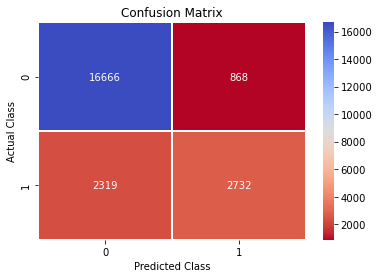

0.7456895861595778

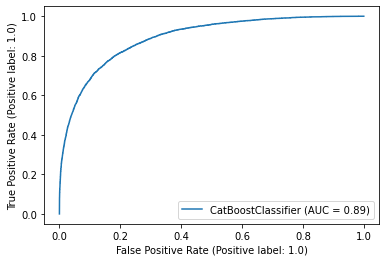

In [46]:
y_pred40 = cat.predict(X_val)
print(classification_report(y_val,y_pred40))

cnf_matrix = confusion_matrix(y_val, y_pred40)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(cat, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred40, average=None) 

### CatBoost- SMOTE

In [47]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_res, y_train_res)

Learning rate set to 0.039882
0:	total: 20.2ms	remaining: 40.3s
1:	total: 31.7ms	remaining: 31.6s
2:	total: 43.4ms	remaining: 28.9s
3:	total: 55.8ms	remaining: 27.9s
4:	total: 78.4ms	remaining: 31.3s
5:	total: 91.1ms	remaining: 30.3s
6:	total: 102ms	remaining: 29.1s
7:	total: 113ms	remaining: 28.2s
8:	total: 124ms	remaining: 27.5s
9:	total: 134ms	remaining: 26.7s
10:	total: 145ms	remaining: 26.1s
11:	total: 155ms	remaining: 25.7s
12:	total: 166ms	remaining: 25.3s
13:	total: 175ms	remaining: 24.9s
14:	total: 187ms	remaining: 24.7s
15:	total: 197ms	remaining: 24.5s
16:	total: 208ms	remaining: 24.2s
17:	total: 219ms	remaining: 24.1s
18:	total: 229ms	remaining: 23.9s
19:	total: 239ms	remaining: 23.7s
20:	total: 250ms	remaining: 23.5s
21:	total: 260ms	remaining: 23.4s
22:	total: 270ms	remaining: 23.2s
23:	total: 281ms	remaining: 23.2s
24:	total: 293ms	remaining: 23.1s
25:	total: 303ms	remaining: 23s
26:	total: 313ms	remaining: 22.9s
27:	total: 324ms	remaining: 22.8s
28:	total: 334ms	remaini

239:	total: 2.52s	remaining: 18.5s
240:	total: 2.53s	remaining: 18.5s
241:	total: 2.54s	remaining: 18.4s
242:	total: 2.55s	remaining: 18.4s
243:	total: 2.56s	remaining: 18.4s
244:	total: 2.57s	remaining: 18.4s
245:	total: 2.58s	remaining: 18.4s
246:	total: 2.59s	remaining: 18.4s
247:	total: 2.6s	remaining: 18.4s
248:	total: 2.61s	remaining: 18.3s
249:	total: 2.62s	remaining: 18.3s
250:	total: 2.63s	remaining: 18.3s
251:	total: 2.64s	remaining: 18.3s
252:	total: 2.65s	remaining: 18.3s
253:	total: 2.66s	remaining: 18.3s
254:	total: 2.67s	remaining: 18.2s
255:	total: 2.68s	remaining: 18.2s
256:	total: 2.69s	remaining: 18.2s
257:	total: 2.69s	remaining: 18.2s
258:	total: 2.71s	remaining: 18.2s
259:	total: 2.72s	remaining: 18.2s
260:	total: 2.73s	remaining: 18.2s
261:	total: 2.74s	remaining: 18.1s
262:	total: 2.75s	remaining: 18.1s
263:	total: 2.76s	remaining: 18.1s
264:	total: 2.77s	remaining: 18.1s
265:	total: 2.78s	remaining: 18.1s
266:	total: 2.79s	remaining: 18.1s
267:	total: 2.8s	rema

485:	total: 5.01s	remaining: 15.6s
486:	total: 5.02s	remaining: 15.6s
487:	total: 5.03s	remaining: 15.6s
488:	total: 5.04s	remaining: 15.6s
489:	total: 5.05s	remaining: 15.6s
490:	total: 5.06s	remaining: 15.5s
491:	total: 5.07s	remaining: 15.5s
492:	total: 5.08s	remaining: 15.5s
493:	total: 5.09s	remaining: 15.5s
494:	total: 5.1s	remaining: 15.5s
495:	total: 5.11s	remaining: 15.5s
496:	total: 5.12s	remaining: 15.5s
497:	total: 5.13s	remaining: 15.5s
498:	total: 5.14s	remaining: 15.4s
499:	total: 5.14s	remaining: 15.4s
500:	total: 5.16s	remaining: 15.4s
501:	total: 5.17s	remaining: 15.4s
502:	total: 5.18s	remaining: 15.4s
503:	total: 5.19s	remaining: 15.4s
504:	total: 5.2s	remaining: 15.4s
505:	total: 5.21s	remaining: 15.4s
506:	total: 5.22s	remaining: 15.4s
507:	total: 5.22s	remaining: 15.3s
508:	total: 5.23s	remaining: 15.3s
509:	total: 5.24s	remaining: 15.3s
510:	total: 5.25s	remaining: 15.3s
511:	total: 5.26s	remaining: 15.3s
512:	total: 5.27s	remaining: 15.3s
513:	total: 5.28s	rema

729:	total: 7.48s	remaining: 13s
730:	total: 7.49s	remaining: 13s
731:	total: 7.5s	remaining: 13s
732:	total: 7.51s	remaining: 13s
733:	total: 7.52s	remaining: 13s
734:	total: 7.53s	remaining: 13s
735:	total: 7.54s	remaining: 12.9s
736:	total: 7.55s	remaining: 12.9s
737:	total: 7.56s	remaining: 12.9s
738:	total: 7.57s	remaining: 12.9s
739:	total: 7.58s	remaining: 12.9s
740:	total: 7.58s	remaining: 12.9s
741:	total: 7.6s	remaining: 12.9s
742:	total: 7.61s	remaining: 12.9s
743:	total: 7.61s	remaining: 12.9s
744:	total: 7.62s	remaining: 12.8s
745:	total: 7.63s	remaining: 12.8s
746:	total: 7.64s	remaining: 12.8s
747:	total: 7.65s	remaining: 12.8s
748:	total: 7.67s	remaining: 12.8s
749:	total: 7.67s	remaining: 12.8s
750:	total: 7.69s	remaining: 12.8s
751:	total: 7.7s	remaining: 12.8s
752:	total: 7.71s	remaining: 12.8s
753:	total: 7.72s	remaining: 12.8s
754:	total: 7.73s	remaining: 12.7s
755:	total: 7.74s	remaining: 12.7s
756:	total: 7.75s	remaining: 12.7s
757:	total: 7.76s	remaining: 12.7s


981:	total: 10s	remaining: 10.4s
982:	total: 10s	remaining: 10.4s
983:	total: 10s	remaining: 10.4s
984:	total: 10s	remaining: 10.4s
985:	total: 10.1s	remaining: 10.3s
986:	total: 10.1s	remaining: 10.3s
987:	total: 10.1s	remaining: 10.3s
988:	total: 10.1s	remaining: 10.3s
989:	total: 10.1s	remaining: 10.3s
990:	total: 10.1s	remaining: 10.3s
991:	total: 10.1s	remaining: 10.3s
992:	total: 10.1s	remaining: 10.3s
993:	total: 10.1s	remaining: 10.3s
994:	total: 10.1s	remaining: 10.2s
995:	total: 10.2s	remaining: 10.2s
996:	total: 10.2s	remaining: 10.2s
997:	total: 10.2s	remaining: 10.2s
998:	total: 10.2s	remaining: 10.2s
999:	total: 10.2s	remaining: 10.2s
1000:	total: 10.2s	remaining: 10.2s
1001:	total: 10.2s	remaining: 10.2s
1002:	total: 10.2s	remaining: 10.2s
1003:	total: 10.2s	remaining: 10.2s
1004:	total: 10.2s	remaining: 10.1s
1005:	total: 10.3s	remaining: 10.1s
1006:	total: 10.3s	remaining: 10.1s
1007:	total: 10.3s	remaining: 10.1s
1008:	total: 10.3s	remaining: 10.1s
1009:	total: 10.3s	

1229:	total: 12.5s	remaining: 7.83s
1230:	total: 12.5s	remaining: 7.82s
1231:	total: 12.5s	remaining: 7.81s
1232:	total: 12.5s	remaining: 7.8s
1233:	total: 12.5s	remaining: 7.79s
1234:	total: 12.6s	remaining: 7.78s
1235:	total: 12.6s	remaining: 7.77s
1236:	total: 12.6s	remaining: 7.76s
1237:	total: 12.6s	remaining: 7.75s
1238:	total: 12.6s	remaining: 7.74s
1239:	total: 12.6s	remaining: 7.73s
1240:	total: 12.6s	remaining: 7.72s
1241:	total: 12.6s	remaining: 7.71s
1242:	total: 12.6s	remaining: 7.7s
1243:	total: 12.7s	remaining: 7.69s
1244:	total: 12.7s	remaining: 7.68s
1245:	total: 12.7s	remaining: 7.67s
1246:	total: 12.7s	remaining: 7.66s
1247:	total: 12.7s	remaining: 7.65s
1248:	total: 12.7s	remaining: 7.63s
1249:	total: 12.7s	remaining: 7.63s
1250:	total: 12.7s	remaining: 7.61s
1251:	total: 12.7s	remaining: 7.6s
1252:	total: 12.7s	remaining: 7.59s
1253:	total: 12.7s	remaining: 7.58s
1254:	total: 12.8s	remaining: 7.57s
1255:	total: 12.8s	remaining: 7.56s
1256:	total: 12.8s	remaining: 7

1462:	total: 14.8s	remaining: 5.45s
1463:	total: 14.9s	remaining: 5.44s
1464:	total: 14.9s	remaining: 5.43s
1465:	total: 14.9s	remaining: 5.42s
1466:	total: 14.9s	remaining: 5.41s
1467:	total: 14.9s	remaining: 5.4s
1468:	total: 14.9s	remaining: 5.39s
1469:	total: 14.9s	remaining: 5.38s
1470:	total: 14.9s	remaining: 5.37s
1471:	total: 14.9s	remaining: 5.36s
1472:	total: 14.9s	remaining: 5.34s
1473:	total: 15s	remaining: 5.33s
1474:	total: 15s	remaining: 5.33s
1475:	total: 15s	remaining: 5.31s
1476:	total: 15s	remaining: 5.3s
1477:	total: 15s	remaining: 5.29s
1478:	total: 15s	remaining: 5.28s
1479:	total: 15s	remaining: 5.27s
1480:	total: 15s	remaining: 5.26s
1481:	total: 15s	remaining: 5.25s
1482:	total: 15s	remaining: 5.24s
1483:	total: 15.1s	remaining: 5.23s
1484:	total: 15.1s	remaining: 5.22s
1485:	total: 15.1s	remaining: 5.21s
1486:	total: 15.1s	remaining: 5.2s
1487:	total: 15.1s	remaining: 5.19s
1488:	total: 15.1s	remaining: 5.18s
1489:	total: 15.1s	remaining: 5.17s
1490:	total: 15

1710:	total: 17.4s	remaining: 2.93s
1711:	total: 17.4s	remaining: 2.92s
1712:	total: 17.4s	remaining: 2.91s
1713:	total: 17.4s	remaining: 2.9s
1714:	total: 17.4s	remaining: 2.89s
1715:	total: 17.4s	remaining: 2.88s
1716:	total: 17.4s	remaining: 2.87s
1717:	total: 17.4s	remaining: 2.86s
1718:	total: 17.4s	remaining: 2.85s
1719:	total: 17.5s	remaining: 2.84s
1720:	total: 17.5s	remaining: 2.83s
1721:	total: 17.5s	remaining: 2.82s
1722:	total: 17.5s	remaining: 2.81s
1723:	total: 17.5s	remaining: 2.8s
1724:	total: 17.5s	remaining: 2.79s
1725:	total: 17.5s	remaining: 2.78s
1726:	total: 17.5s	remaining: 2.77s
1727:	total: 17.5s	remaining: 2.76s
1728:	total: 17.5s	remaining: 2.75s
1729:	total: 17.6s	remaining: 2.74s
1730:	total: 17.6s	remaining: 2.73s
1731:	total: 17.6s	remaining: 2.72s
1732:	total: 17.6s	remaining: 2.71s
1733:	total: 17.6s	remaining: 2.7s
1734:	total: 17.6s	remaining: 2.69s
1735:	total: 17.6s	remaining: 2.68s
1736:	total: 17.6s	remaining: 2.67s
1737:	total: 17.6s	remaining: 2

1956:	total: 19.9s	remaining: 437ms
1957:	total: 19.9s	remaining: 427ms
1958:	total: 19.9s	remaining: 416ms
1959:	total: 19.9s	remaining: 406ms
1960:	total: 19.9s	remaining: 396ms
1961:	total: 19.9s	remaining: 386ms
1962:	total: 19.9s	remaining: 376ms
1963:	total: 19.9s	remaining: 366ms
1964:	total: 20s	remaining: 355ms
1965:	total: 20s	remaining: 345ms
1966:	total: 20s	remaining: 335ms
1967:	total: 20s	remaining: 325ms
1968:	total: 20s	remaining: 315ms
1969:	total: 20s	remaining: 305ms
1970:	total: 20s	remaining: 294ms
1971:	total: 20s	remaining: 284ms
1972:	total: 20s	remaining: 274ms
1973:	total: 20s	remaining: 264ms
1974:	total: 20.1s	remaining: 254ms
1975:	total: 20.1s	remaining: 244ms
1976:	total: 20.1s	remaining: 234ms
1977:	total: 20.1s	remaining: 223ms
1978:	total: 20.1s	remaining: 213ms
1979:	total: 20.1s	remaining: 203ms
1980:	total: 20.1s	remaining: 193ms
1981:	total: 20.1s	remaining: 183ms
1982:	total: 20.1s	remaining: 173ms
1983:	total: 20.1s	remaining: 162ms
1984:	total:

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     17534
         1.0       0.74      0.56      0.64      5051

    accuracy                           0.86     22585
   macro avg       0.81      0.75      0.78     22585
weighted avg       0.85      0.86      0.85     22585



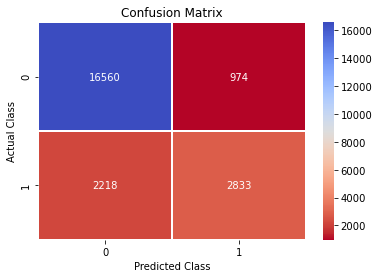

0.7526649075968974

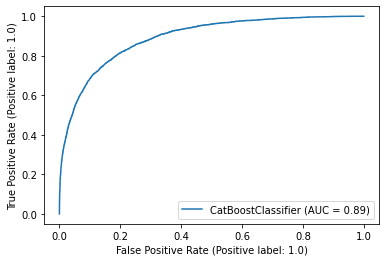

In [48]:
y_pred41 = cat.predict(X_val)
print(classification_report(y_val,y_pred41))

cnf_matrix = confusion_matrix(y_val, y_pred41)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(cat, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred41, average=None) 

### CatBoost - ADA

In [49]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_ada, y_train_ada)

Learning rate set to 0.040076
0:	total: 35.1ms	remaining: 1m 10s
1:	total: 46.9ms	remaining: 46.8s
2:	total: 58.8ms	remaining: 39.2s
3:	total: 71.1ms	remaining: 35.5s
4:	total: 83.5ms	remaining: 33.3s
5:	total: 95.6ms	remaining: 31.8s
6:	total: 108ms	remaining: 30.7s
7:	total: 119ms	remaining: 29.6s
8:	total: 130ms	remaining: 28.8s
9:	total: 142ms	remaining: 28.2s
10:	total: 152ms	remaining: 27.5s
11:	total: 163ms	remaining: 26.9s
12:	total: 174ms	remaining: 26.5s
13:	total: 184ms	remaining: 26.2s
14:	total: 196ms	remaining: 25.9s
15:	total: 207ms	remaining: 25.6s
16:	total: 218ms	remaining: 25.4s
17:	total: 229ms	remaining: 25.3s
18:	total: 240ms	remaining: 25.1s
19:	total: 252ms	remaining: 24.9s
20:	total: 264ms	remaining: 24.8s
21:	total: 274ms	remaining: 24.6s
22:	total: 285ms	remaining: 24.5s
23:	total: 295ms	remaining: 24.3s
24:	total: 305ms	remaining: 24.1s
25:	total: 316ms	remaining: 24s
26:	total: 327ms	remaining: 23.9s
27:	total: 337ms	remaining: 23.7s
28:	total: 348ms	remain

255:	total: 2.7s	remaining: 18.4s
256:	total: 2.71s	remaining: 18.4s
257:	total: 2.72s	remaining: 18.4s
258:	total: 2.73s	remaining: 18.3s
259:	total: 2.74s	remaining: 18.3s
260:	total: 2.75s	remaining: 18.3s
261:	total: 2.76s	remaining: 18.3s
262:	total: 2.77s	remaining: 18.3s
263:	total: 2.78s	remaining: 18.3s
264:	total: 2.79s	remaining: 18.3s
265:	total: 2.8s	remaining: 18.3s
266:	total: 2.81s	remaining: 18.3s
267:	total: 2.82s	remaining: 18.2s
268:	total: 2.83s	remaining: 18.2s
269:	total: 2.84s	remaining: 18.2s
270:	total: 2.85s	remaining: 18.2s
271:	total: 2.86s	remaining: 18.2s
272:	total: 2.87s	remaining: 18.2s
273:	total: 2.88s	remaining: 18.1s
274:	total: 2.89s	remaining: 18.1s
275:	total: 2.9s	remaining: 18.1s
276:	total: 2.91s	remaining: 18.1s
277:	total: 2.92s	remaining: 18.1s
278:	total: 2.93s	remaining: 18.1s
279:	total: 2.94s	remaining: 18.1s
280:	total: 2.95s	remaining: 18.1s
281:	total: 2.96s	remaining: 18s
282:	total: 2.97s	remaining: 18s
283:	total: 2.98s	remaining

493:	total: 5.21s	remaining: 15.9s
494:	total: 5.22s	remaining: 15.9s
495:	total: 5.23s	remaining: 15.9s
496:	total: 5.24s	remaining: 15.8s
497:	total: 5.25s	remaining: 15.8s
498:	total: 5.26s	remaining: 15.8s
499:	total: 5.27s	remaining: 15.8s
500:	total: 5.28s	remaining: 15.8s
501:	total: 5.29s	remaining: 15.8s
502:	total: 5.3s	remaining: 15.8s
503:	total: 5.32s	remaining: 15.8s
504:	total: 5.33s	remaining: 15.8s
505:	total: 5.34s	remaining: 15.8s
506:	total: 5.35s	remaining: 15.7s
507:	total: 5.36s	remaining: 15.7s
508:	total: 5.37s	remaining: 15.7s
509:	total: 5.38s	remaining: 15.7s
510:	total: 5.39s	remaining: 15.7s
511:	total: 5.4s	remaining: 15.7s
512:	total: 5.41s	remaining: 15.7s
513:	total: 5.42s	remaining: 15.7s
514:	total: 5.43s	remaining: 15.7s
515:	total: 5.44s	remaining: 15.7s
516:	total: 5.46s	remaining: 15.6s
517:	total: 5.46s	remaining: 15.6s
518:	total: 5.47s	remaining: 15.6s
519:	total: 5.49s	remaining: 15.6s
520:	total: 5.5s	remaining: 15.6s
521:	total: 5.51s	remai

745:	total: 7.91s	remaining: 13.3s
746:	total: 7.92s	remaining: 13.3s
747:	total: 7.93s	remaining: 13.3s
748:	total: 7.94s	remaining: 13.3s
749:	total: 7.95s	remaining: 13.2s
750:	total: 7.96s	remaining: 13.2s
751:	total: 7.97s	remaining: 13.2s
752:	total: 7.98s	remaining: 13.2s
753:	total: 7.99s	remaining: 13.2s
754:	total: 8s	remaining: 13.2s
755:	total: 8.01s	remaining: 13.2s
756:	total: 8.02s	remaining: 13.2s
757:	total: 8.03s	remaining: 13.2s
758:	total: 8.04s	remaining: 13.1s
759:	total: 8.05s	remaining: 13.1s
760:	total: 8.06s	remaining: 13.1s
761:	total: 8.07s	remaining: 13.1s
762:	total: 8.08s	remaining: 13.1s
763:	total: 8.09s	remaining: 13.1s
764:	total: 8.1s	remaining: 13.1s
765:	total: 8.11s	remaining: 13.1s
766:	total: 8.12s	remaining: 13.1s
767:	total: 8.13s	remaining: 13s
768:	total: 8.14s	remaining: 13s
769:	total: 8.15s	remaining: 13s
770:	total: 8.17s	remaining: 13s
771:	total: 8.18s	remaining: 13s
772:	total: 8.19s	remaining: 13s
773:	total: 8.2s	remaining: 13s
774:

985:	total: 10.4s	remaining: 10.7s
986:	total: 10.4s	remaining: 10.7s
987:	total: 10.4s	remaining: 10.7s
988:	total: 10.4s	remaining: 10.7s
989:	total: 10.4s	remaining: 10.6s
990:	total: 10.4s	remaining: 10.6s
991:	total: 10.5s	remaining: 10.6s
992:	total: 10.5s	remaining: 10.6s
993:	total: 10.5s	remaining: 10.6s
994:	total: 10.5s	remaining: 10.6s
995:	total: 10.5s	remaining: 10.6s
996:	total: 10.5s	remaining: 10.6s
997:	total: 10.5s	remaining: 10.6s
998:	total: 10.5s	remaining: 10.5s
999:	total: 10.5s	remaining: 10.5s
1000:	total: 10.5s	remaining: 10.5s
1001:	total: 10.5s	remaining: 10.5s
1002:	total: 10.6s	remaining: 10.5s
1003:	total: 10.6s	remaining: 10.5s
1004:	total: 10.6s	remaining: 10.5s
1005:	total: 10.6s	remaining: 10.5s
1006:	total: 10.6s	remaining: 10.5s
1007:	total: 10.6s	remaining: 10.4s
1008:	total: 10.6s	remaining: 10.4s
1009:	total: 10.6s	remaining: 10.4s
1010:	total: 10.6s	remaining: 10.4s
1011:	total: 10.7s	remaining: 10.4s
1012:	total: 10.7s	remaining: 10.4s
1013:	t

1231:	total: 12.9s	remaining: 8.05s
1232:	total: 12.9s	remaining: 8.04s
1233:	total: 12.9s	remaining: 8.03s
1234:	total: 13s	remaining: 8.02s
1235:	total: 13s	remaining: 8.01s
1236:	total: 13s	remaining: 8s
1237:	total: 13s	remaining: 7.99s
1238:	total: 13s	remaining: 7.98s
1239:	total: 13s	remaining: 7.97s
1240:	total: 13s	remaining: 7.96s
1241:	total: 13s	remaining: 7.95s
1242:	total: 13s	remaining: 7.94s
1243:	total: 13s	remaining: 7.93s
1244:	total: 13.1s	remaining: 7.92s
1245:	total: 13.1s	remaining: 7.91s
1246:	total: 13.1s	remaining: 7.9s
1247:	total: 13.1s	remaining: 7.89s
1248:	total: 13.1s	remaining: 7.88s
1249:	total: 13.1s	remaining: 7.87s
1250:	total: 13.1s	remaining: 7.86s
1251:	total: 13.1s	remaining: 7.84s
1252:	total: 13.1s	remaining: 7.83s
1253:	total: 13.2s	remaining: 7.82s
1254:	total: 13.2s	remaining: 7.81s
1255:	total: 13.2s	remaining: 7.8s
1256:	total: 13.2s	remaining: 7.79s
1257:	total: 13.2s	remaining: 7.78s
1258:	total: 13.2s	remaining: 7.77s
1259:	total: 13.2

1466:	total: 15.4s	remaining: 5.6s
1467:	total: 15.4s	remaining: 5.59s
1468:	total: 15.4s	remaining: 5.58s
1469:	total: 15.5s	remaining: 5.57s
1470:	total: 15.5s	remaining: 5.56s
1471:	total: 15.5s	remaining: 5.55s
1472:	total: 15.5s	remaining: 5.54s
1473:	total: 15.5s	remaining: 5.53s
1474:	total: 15.5s	remaining: 5.52s
1475:	total: 15.5s	remaining: 5.51s
1476:	total: 15.5s	remaining: 5.5s
1477:	total: 15.5s	remaining: 5.49s
1478:	total: 15.5s	remaining: 5.48s
1479:	total: 15.6s	remaining: 5.47s
1480:	total: 15.6s	remaining: 5.46s
1481:	total: 15.6s	remaining: 5.45s
1482:	total: 15.6s	remaining: 5.43s
1483:	total: 15.6s	remaining: 5.42s
1484:	total: 15.6s	remaining: 5.41s
1485:	total: 15.6s	remaining: 5.4s
1486:	total: 15.6s	remaining: 5.39s
1487:	total: 15.6s	remaining: 5.38s
1488:	total: 15.7s	remaining: 5.37s
1489:	total: 15.7s	remaining: 5.36s
1490:	total: 15.7s	remaining: 5.35s
1491:	total: 15.7s	remaining: 5.34s
1492:	total: 15.7s	remaining: 5.33s
1493:	total: 15.7s	remaining: 5

1706:	total: 17.9s	remaining: 3.08s
1707:	total: 17.9s	remaining: 3.07s
1708:	total: 18s	remaining: 3.06s
1709:	total: 18s	remaining: 3.05s
1710:	total: 18s	remaining: 3.04s
1711:	total: 18s	remaining: 3.03s
1712:	total: 18s	remaining: 3.02s
1713:	total: 18s	remaining: 3s
1714:	total: 18s	remaining: 2.99s
1715:	total: 18s	remaining: 2.98s
1716:	total: 18s	remaining: 2.97s
1717:	total: 18.1s	remaining: 2.96s
1718:	total: 18.1s	remaining: 2.95s
1719:	total: 18.1s	remaining: 2.94s
1720:	total: 18.1s	remaining: 2.93s
1721:	total: 18.1s	remaining: 2.92s
1722:	total: 18.1s	remaining: 2.91s
1723:	total: 18.1s	remaining: 2.9s
1724:	total: 18.1s	remaining: 2.89s
1725:	total: 18.1s	remaining: 2.88s
1726:	total: 18.1s	remaining: 2.87s
1727:	total: 18.2s	remaining: 2.86s
1728:	total: 18.2s	remaining: 2.85s
1729:	total: 18.2s	remaining: 2.84s
1730:	total: 18.2s	remaining: 2.83s
1731:	total: 18.2s	remaining: 2.81s
1732:	total: 18.2s	remaining: 2.8s
1733:	total: 18.2s	remaining: 2.79s
1734:	total: 18

1947:	total: 20.4s	remaining: 545ms
1948:	total: 20.4s	remaining: 534ms
1949:	total: 20.4s	remaining: 524ms
1950:	total: 20.4s	remaining: 513ms
1951:	total: 20.4s	remaining: 503ms
1952:	total: 20.4s	remaining: 492ms
1953:	total: 20.5s	remaining: 482ms
1954:	total: 20.5s	remaining: 471ms
1955:	total: 20.5s	remaining: 461ms
1956:	total: 20.5s	remaining: 450ms
1957:	total: 20.5s	remaining: 440ms
1958:	total: 20.5s	remaining: 429ms
1959:	total: 20.5s	remaining: 419ms
1960:	total: 20.5s	remaining: 408ms
1961:	total: 20.5s	remaining: 398ms
1962:	total: 20.6s	remaining: 387ms
1963:	total: 20.6s	remaining: 377ms
1964:	total: 20.6s	remaining: 366ms
1965:	total: 20.6s	remaining: 356ms
1966:	total: 20.6s	remaining: 346ms
1967:	total: 20.6s	remaining: 335ms
1968:	total: 20.6s	remaining: 325ms
1969:	total: 20.6s	remaining: 314ms
1970:	total: 20.6s	remaining: 304ms
1971:	total: 20.6s	remaining: 293ms
1972:	total: 20.7s	remaining: 283ms
1973:	total: 20.7s	remaining: 272ms
1974:	total: 20.7s	remaining

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     17534
         1.0       0.75      0.56      0.64      5051

    accuracy                           0.86     22585
   macro avg       0.82      0.75      0.78     22585
weighted avg       0.85      0.86      0.85     22585



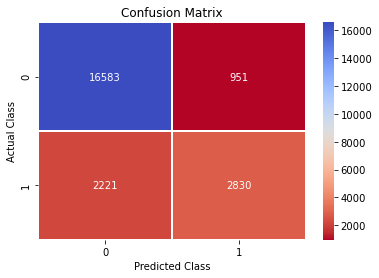

0.7530238052981975

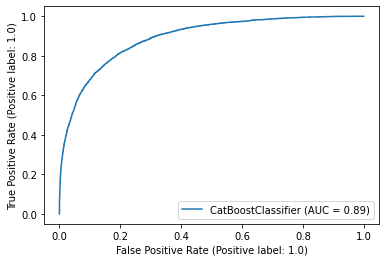

In [50]:
y_pred42 = cat.predict(X_val)
print(classification_report(y_val, y_pred42))

cnf_matrix = confusion_matrix(y_val, y_pred42)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(cat, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred42, average=None) 

### CatBoost - RandomOverSampling

In [51]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_over, y_train_over)

Learning rate set to 0.039882
0:	total: 34.4ms	remaining: 1m 8s
1:	total: 41.2ms	remaining: 41.2s
2:	total: 48.2ms	remaining: 32.1s
3:	total: 54.9ms	remaining: 27.4s
4:	total: 62.4ms	remaining: 24.9s
5:	total: 69.7ms	remaining: 23.2s
6:	total: 76.6ms	remaining: 21.8s
7:	total: 84.4ms	remaining: 21s
8:	total: 92.2ms	remaining: 20.4s
9:	total: 99.3ms	remaining: 19.8s
10:	total: 106ms	remaining: 19.2s
11:	total: 113ms	remaining: 18.7s
12:	total: 120ms	remaining: 18.4s
13:	total: 127ms	remaining: 18s
14:	total: 133ms	remaining: 17.6s
15:	total: 140ms	remaining: 17.3s
16:	total: 146ms	remaining: 17s
17:	total: 152ms	remaining: 16.8s
18:	total: 159ms	remaining: 16.6s
19:	total: 165ms	remaining: 16.3s
20:	total: 172ms	remaining: 16.2s
21:	total: 179ms	remaining: 16.1s
22:	total: 185ms	remaining: 15.9s
23:	total: 190ms	remaining: 15.7s
24:	total: 197ms	remaining: 15.6s
25:	total: 204ms	remaining: 15.5s
26:	total: 209ms	remaining: 15.3s
27:	total: 216ms	remaining: 15.2s
28:	total: 222ms	remaini

246:	total: 1.64s	remaining: 11.7s
247:	total: 1.65s	remaining: 11.7s
248:	total: 1.66s	remaining: 11.6s
249:	total: 1.66s	remaining: 11.6s
250:	total: 1.67s	remaining: 11.6s
251:	total: 1.67s	remaining: 11.6s
252:	total: 1.68s	remaining: 11.6s
253:	total: 1.69s	remaining: 11.6s
254:	total: 1.69s	remaining: 11.6s
255:	total: 1.7s	remaining: 11.6s
256:	total: 1.7s	remaining: 11.6s
257:	total: 1.71s	remaining: 11.6s
258:	total: 1.72s	remaining: 11.5s
259:	total: 1.72s	remaining: 11.5s
260:	total: 1.73s	remaining: 11.5s
261:	total: 1.74s	remaining: 11.5s
262:	total: 1.74s	remaining: 11.5s
263:	total: 1.75s	remaining: 11.5s
264:	total: 1.75s	remaining: 11.5s
265:	total: 1.76s	remaining: 11.5s
266:	total: 1.77s	remaining: 11.5s
267:	total: 1.77s	remaining: 11.5s
268:	total: 1.78s	remaining: 11.4s
269:	total: 1.78s	remaining: 11.4s
270:	total: 1.79s	remaining: 11.4s
271:	total: 1.8s	remaining: 11.4s
272:	total: 1.8s	remaining: 11.4s
273:	total: 1.81s	remaining: 11.4s
274:	total: 1.81s	remain

483:	total: 3.11s	remaining: 9.74s
484:	total: 3.12s	remaining: 9.73s
485:	total: 3.12s	remaining: 9.72s
486:	total: 3.13s	remaining: 9.72s
487:	total: 3.13s	remaining: 9.71s
488:	total: 3.14s	remaining: 9.71s
489:	total: 3.15s	remaining: 9.7s
490:	total: 3.15s	remaining: 9.69s
491:	total: 3.16s	remaining: 9.68s
492:	total: 3.17s	remaining: 9.68s
493:	total: 3.17s	remaining: 9.67s
494:	total: 3.18s	remaining: 9.66s
495:	total: 3.18s	remaining: 9.65s
496:	total: 3.19s	remaining: 9.65s
497:	total: 3.2s	remaining: 9.64s
498:	total: 3.2s	remaining: 9.63s
499:	total: 3.21s	remaining: 9.63s
500:	total: 3.21s	remaining: 9.62s
501:	total: 3.22s	remaining: 9.61s
502:	total: 3.23s	remaining: 9.6s
503:	total: 3.23s	remaining: 9.6s
504:	total: 3.24s	remaining: 9.59s
505:	total: 3.25s	remaining: 9.58s
506:	total: 3.25s	remaining: 9.57s
507:	total: 3.26s	remaining: 9.57s
508:	total: 3.26s	remaining: 9.56s
509:	total: 3.27s	remaining: 9.55s
510:	total: 3.28s	remaining: 9.55s
511:	total: 3.28s	remaini

744:	total: 4.75s	remaining: 8s
745:	total: 4.75s	remaining: 7.99s
746:	total: 4.76s	remaining: 7.99s
747:	total: 4.77s	remaining: 7.98s
748:	total: 4.78s	remaining: 7.97s
749:	total: 4.78s	remaining: 7.97s
750:	total: 4.79s	remaining: 7.96s
751:	total: 4.79s	remaining: 7.95s
752:	total: 4.8s	remaining: 7.95s
753:	total: 4.8s	remaining: 7.94s
754:	total: 4.81s	remaining: 7.93s
755:	total: 4.82s	remaining: 7.93s
756:	total: 4.82s	remaining: 7.92s
757:	total: 4.83s	remaining: 7.92s
758:	total: 4.84s	remaining: 7.91s
759:	total: 4.84s	remaining: 7.9s
760:	total: 4.85s	remaining: 7.9s
761:	total: 4.86s	remaining: 7.89s
762:	total: 4.86s	remaining: 7.88s
763:	total: 4.87s	remaining: 7.88s
764:	total: 4.88s	remaining: 7.87s
765:	total: 4.88s	remaining: 7.86s
766:	total: 4.89s	remaining: 7.86s
767:	total: 4.89s	remaining: 7.85s
768:	total: 4.9s	remaining: 7.84s
769:	total: 4.91s	remaining: 7.84s
770:	total: 4.91s	remaining: 7.83s
771:	total: 4.92s	remaining: 7.82s
772:	total: 4.92s	remaining:

1009:	total: 6.4s	remaining: 6.27s
1010:	total: 6.41s	remaining: 6.27s
1011:	total: 6.41s	remaining: 6.26s
1012:	total: 6.42s	remaining: 6.25s
1013:	total: 6.42s	remaining: 6.25s
1014:	total: 6.43s	remaining: 6.24s
1015:	total: 6.44s	remaining: 6.23s
1016:	total: 6.44s	remaining: 6.23s
1017:	total: 6.45s	remaining: 6.22s
1018:	total: 6.46s	remaining: 6.21s
1019:	total: 6.46s	remaining: 6.21s
1020:	total: 6.47s	remaining: 6.2s
1021:	total: 6.47s	remaining: 6.19s
1022:	total: 6.48s	remaining: 6.19s
1023:	total: 6.49s	remaining: 6.18s
1024:	total: 6.49s	remaining: 6.17s
1025:	total: 6.5s	remaining: 6.17s
1026:	total: 6.5s	remaining: 6.16s
1027:	total: 6.51s	remaining: 6.15s
1028:	total: 6.51s	remaining: 6.15s
1029:	total: 6.52s	remaining: 6.14s
1030:	total: 6.53s	remaining: 6.14s
1031:	total: 6.54s	remaining: 6.13s
1032:	total: 6.54s	remaining: 6.12s
1033:	total: 6.55s	remaining: 6.12s
1034:	total: 6.55s	remaining: 6.11s
1035:	total: 6.56s	remaining: 6.11s
1036:	total: 6.57s	remaining: 6.

1242:	total: 7.86s	remaining: 4.79s
1243:	total: 7.87s	remaining: 4.78s
1244:	total: 7.88s	remaining: 4.78s
1245:	total: 7.88s	remaining: 4.77s
1246:	total: 7.89s	remaining: 4.76s
1247:	total: 7.89s	remaining: 4.76s
1248:	total: 7.9s	remaining: 4.75s
1249:	total: 7.91s	remaining: 4.74s
1250:	total: 7.91s	remaining: 4.74s
1251:	total: 7.92s	remaining: 4.73s
1252:	total: 7.92s	remaining: 4.72s
1253:	total: 7.93s	remaining: 4.72s
1254:	total: 7.94s	remaining: 4.71s
1255:	total: 7.94s	remaining: 4.71s
1256:	total: 7.95s	remaining: 4.7s
1257:	total: 7.96s	remaining: 4.69s
1258:	total: 7.96s	remaining: 4.69s
1259:	total: 7.97s	remaining: 4.68s
1260:	total: 7.98s	remaining: 4.67s
1261:	total: 7.98s	remaining: 4.67s
1262:	total: 7.99s	remaining: 4.66s
1263:	total: 8s	remaining: 4.66s
1264:	total: 8s	remaining: 4.65s
1265:	total: 8.01s	remaining: 4.64s
1266:	total: 8.01s	remaining: 4.64s
1267:	total: 8.02s	remaining: 4.63s
1268:	total: 8.03s	remaining: 4.63s
1269:	total: 8.04s	remaining: 4.62s


1498:	total: 9.51s	remaining: 3.18s
1499:	total: 9.51s	remaining: 3.17s
1500:	total: 9.52s	remaining: 3.16s
1501:	total: 9.52s	remaining: 3.16s
1502:	total: 9.53s	remaining: 3.15s
1503:	total: 9.54s	remaining: 3.14s
1504:	total: 9.54s	remaining: 3.14s
1505:	total: 9.55s	remaining: 3.13s
1506:	total: 9.55s	remaining: 3.13s
1507:	total: 9.56s	remaining: 3.12s
1508:	total: 9.57s	remaining: 3.11s
1509:	total: 9.57s	remaining: 3.11s
1510:	total: 9.58s	remaining: 3.1s
1511:	total: 9.59s	remaining: 3.09s
1512:	total: 9.59s	remaining: 3.09s
1513:	total: 9.6s	remaining: 3.08s
1514:	total: 9.6s	remaining: 3.07s
1515:	total: 9.61s	remaining: 3.07s
1516:	total: 9.61s	remaining: 3.06s
1517:	total: 9.62s	remaining: 3.05s
1518:	total: 9.63s	remaining: 3.05s
1519:	total: 9.63s	remaining: 3.04s
1520:	total: 9.64s	remaining: 3.04s
1521:	total: 9.64s	remaining: 3.03s
1522:	total: 9.65s	remaining: 3.02s
1523:	total: 9.66s	remaining: 3.02s
1524:	total: 9.66s	remaining: 3.01s
1525:	total: 9.67s	remaining: 3

1728:	total: 11s	remaining: 1.72s
1729:	total: 11s	remaining: 1.71s
1730:	total: 11s	remaining: 1.71s
1731:	total: 11s	remaining: 1.7s
1732:	total: 11s	remaining: 1.69s
1733:	total: 11s	remaining: 1.69s
1734:	total: 11s	remaining: 1.68s
1735:	total: 11s	remaining: 1.68s
1736:	total: 11s	remaining: 1.67s
1737:	total: 11s	remaining: 1.66s
1738:	total: 11s	remaining: 1.66s
1739:	total: 11s	remaining: 1.65s
1740:	total: 11.1s	remaining: 1.64s
1741:	total: 11.1s	remaining: 1.64s
1742:	total: 11.1s	remaining: 1.63s
1743:	total: 11.1s	remaining: 1.62s
1744:	total: 11.1s	remaining: 1.62s
1745:	total: 11.1s	remaining: 1.61s
1746:	total: 11.1s	remaining: 1.6s
1747:	total: 11.1s	remaining: 1.6s
1748:	total: 11.1s	remaining: 1.59s
1749:	total: 11.1s	remaining: 1.59s
1750:	total: 11.1s	remaining: 1.58s
1751:	total: 11.1s	remaining: 1.57s
1752:	total: 11.1s	remaining: 1.57s
1753:	total: 11.1s	remaining: 1.56s
1754:	total: 11.1s	remaining: 1.55s
1755:	total: 11.1s	remaining: 1.55s
1756:	total: 11.2s	

1962:	total: 12.5s	remaining: 235ms
1963:	total: 12.5s	remaining: 228ms
1964:	total: 12.5s	remaining: 222ms
1965:	total: 12.5s	remaining: 216ms
1966:	total: 12.5s	remaining: 209ms
1967:	total: 12.5s	remaining: 203ms
1968:	total: 12.5s	remaining: 197ms
1969:	total: 12.5s	remaining: 190ms
1970:	total: 12.5s	remaining: 184ms
1971:	total: 12.5s	remaining: 178ms
1972:	total: 12.5s	remaining: 171ms
1973:	total: 12.5s	remaining: 165ms
1974:	total: 12.5s	remaining: 159ms
1975:	total: 12.5s	remaining: 152ms
1976:	total: 12.5s	remaining: 146ms
1977:	total: 12.5s	remaining: 140ms
1978:	total: 12.6s	remaining: 133ms
1979:	total: 12.6s	remaining: 127ms
1980:	total: 12.6s	remaining: 120ms
1981:	total: 12.6s	remaining: 114ms
1982:	total: 12.6s	remaining: 108ms
1983:	total: 12.6s	remaining: 101ms
1984:	total: 12.6s	remaining: 95.1ms
1985:	total: 12.6s	remaining: 88.8ms
1986:	total: 12.6s	remaining: 82.4ms
1987:	total: 12.6s	remaining: 76.1ms
1988:	total: 12.6s	remaining: 69.8ms
1989:	total: 12.6s	rema

              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88     17534
         1.0       0.59      0.76      0.66      5051

    accuracy                           0.83     22585
   macro avg       0.76      0.80      0.77     22585
weighted avg       0.85      0.83      0.84     22585



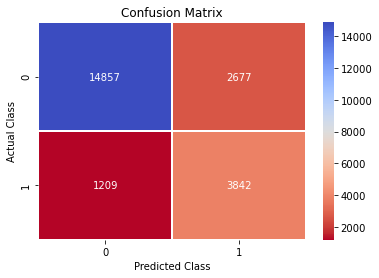

0.7530238052981975

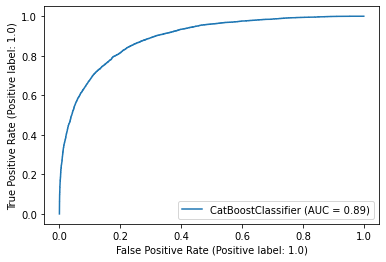

In [52]:
y_pred43 = cat.predict(X_val)
print(classification_report(y_val, y_pred43))

cnf_matrix = confusion_matrix(y_val, y_pred43)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(cat, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred42, average=None) 

# More Eperiments <a class="anchor" id="experiments"></a>

## Label Encoding <a class="anchor" id="label"></a>

In [53]:
df_label_encoded = pd.read_csv("data/weatherAUS.csv")
df_label_encoded.drop(["Sunshine", "Evaporation", "Cloud3pm", "Cloud9am"], axis = 1, inplace = True)
df_label_encoded.dropna(how = 'any', inplace = True)

numerical = list(df_label_encoded._get_numeric_data().columns)
categorical = list(set(df_label_encoded.columns) - set(numerical))

# outliers in numerical columns
for n in numerical:
    q1 = df_label_encoded[n].quantile(0.25)
    q3 = df_label_encoded[n].quantile(0.75)
    IQR = q3 - q1
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR
    df_label_encoded.loc[(df[n] <= lower), n] = lower
    df_label_encoded.loc[(df[n] >= upper), n] = upper  

# label encoding categorical columns
le = LabelEncoder()
for column in categorical:
    df_label_encoded[column]= le.fit_transform(df_label_encoded[column])

df_label_encoded.drop(["Date", "Location"], axis = 1, inplace = True)
df_label_encoded.shape

(112925, 17)

In [54]:
df_label_encoded

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,2.7,0.6,13,5.5,13,14,20.0,24.0,18.5,22.0,998.85,996.2,16.9,1.9,0,0
1,7.4,2.7,0.0,14,5.5,6,15,4.0,22.0,18.5,25.0,998.85,996.2,17.2,1.9,0,0
2,12.9,2.7,0.0,15,5.5,13,15,19.0,26.0,18.5,30.0,998.85,996.2,21.0,1.9,0,0
3,9.2,2.7,0.0,4,5.5,9,0,11.0,9.0,18.5,16.0,998.85,996.2,18.1,1.9,0,0
4,17.5,2.7,1.0,13,5.5,1,7,7.0,20.0,18.5,33.0,998.85,996.2,17.8,1.9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,2.7,0.0,0,5.5,2,0,15.0,13.0,18.5,27.0,998.85,996.2,9.4,1.9,0,0
145455,2.8,2.7,0.0,0,5.5,9,1,13.0,11.0,18.5,24.0,998.85,996.2,10.1,1.9,0,0
145456,3.6,2.7,0.0,6,5.5,9,3,13.0,9.0,18.5,21.0,998.85,996.2,10.9,1.9,0,0
145457,5.4,2.7,0.0,3,5.5,9,14,9.0,9.0,18.5,24.0,998.85,996.2,12.5,1.9,0,0


The number of classes before fit: 67755
The number of classes after fit: 107613


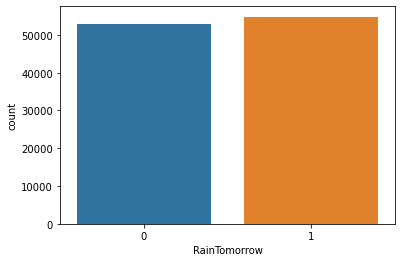

In [55]:
X = df_label_encoded.loc[:,df_label_encoded.columns!='RainTomorrow']
y = df_label_encoded[['RainTomorrow']]

X_train_or, X_test, y_train_or, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size=0.25)
sns.countplot(x = y_train["RainTomorrow"]);

ada = ADASYN()
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

print("The number of classes before fit:", len(y_train.index))
print("The number of classes after fit:", len(y_train_ada.index))
sns.countplot(x = y_train_ada["RainTomorrow"]);

### Models

#### Random Forest

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     17522
           1       0.61      0.59      0.60      5063

    accuracy                           0.82     22585
   macro avg       0.75      0.74      0.74     22585
weighted avg       0.82      0.82      0.82     22585



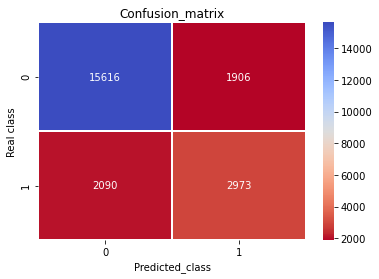

0.7392118636309088

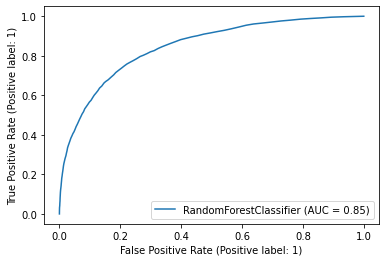

In [56]:
rf=RandomForestClassifier()
rf.fit(X_train_ada, y_train_ada.values.ravel())

y_pred13 = rf.predict(X_val)
print(classification_report(y_val,y_pred13))

cnf_matrix = confusion_matrix(y_val, y_pred13)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5,fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(rf, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred13, average=None)

#### Logistic Regression

              precision    recall  f1-score   support

           0       0.92      0.67      0.77     17522
           1       0.41      0.80      0.54      5063

    accuracy                           0.70     22585
   macro avg       0.67      0.74      0.66     22585
weighted avg       0.81      0.70      0.72     22585



C:\Users\Meshal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


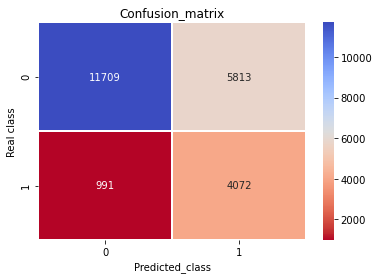

0.736255939684572

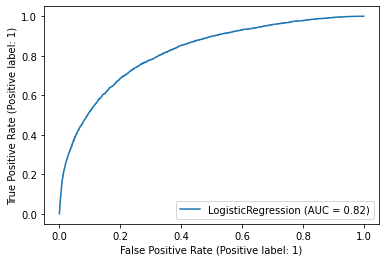

In [57]:
logreg = LogisticRegression()
logreg.fit(X_train_ada, y_train_ada.values.ravel())

y_pred23 = logreg.predict(X_val)
print(classification_report(y_val,y_pred23))

cnf_matrix = confusion_matrix(y_val, y_pred23)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(logreg, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred23, average=None)

#### XGBoost

[17:34:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     17522
           1       0.69      0.50      0.58      5063

    accuracy                           0.84     22585
   macro avg       0.78      0.72      0.74     22585
weighted avg       0.83      0.84      0.83     22585



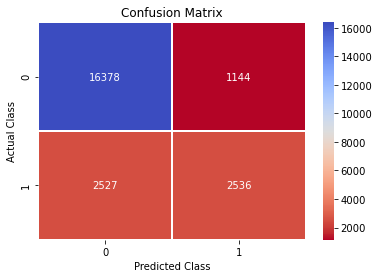

0.7177997252876511

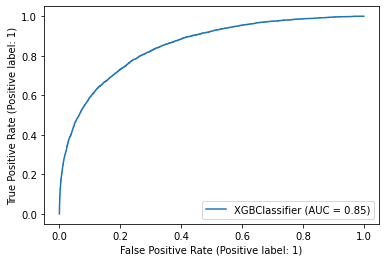

In [58]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train_ada, y_train_ada)

y_pred33 = xgb.predict(X_val)
print(classification_report(y_val,y_pred33))

cnf_matrix = confusion_matrix(y_val, y_pred33)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(xgb, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred33, average=None)


#### CatBoost

In [59]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_ada, y_train_ada)

Learning rate set to 0.040225
0:	total: 18.3ms	remaining: 36.6s
1:	total: 25ms	remaining: 25s
2:	total: 31.6ms	remaining: 21.1s
3:	total: 38ms	remaining: 18.9s
4:	total: 44.2ms	remaining: 17.6s
5:	total: 50.8ms	remaining: 16.9s
6:	total: 57.4ms	remaining: 16.3s
7:	total: 63.4ms	remaining: 15.8s
8:	total: 70.2ms	remaining: 15.5s
9:	total: 76.9ms	remaining: 15.3s
10:	total: 83.6ms	remaining: 15.1s
11:	total: 90.1ms	remaining: 14.9s
12:	total: 96.5ms	remaining: 14.7s
13:	total: 103ms	remaining: 14.7s
14:	total: 110ms	remaining: 14.6s
15:	total: 116ms	remaining: 14.4s
16:	total: 122ms	remaining: 14.3s
17:	total: 128ms	remaining: 14.1s
18:	total: 135ms	remaining: 14.1s
19:	total: 141ms	remaining: 14s
20:	total: 148ms	remaining: 13.9s
21:	total: 154ms	remaining: 13.8s
22:	total: 160ms	remaining: 13.8s
23:	total: 167ms	remaining: 13.7s
24:	total: 173ms	remaining: 13.7s
25:	total: 180ms	remaining: 13.6s
26:	total: 186ms	remaining: 13.6s
27:	total: 192ms	remaining: 13.6s
28:	total: 199ms	remain

260:	total: 1.65s	remaining: 11s
261:	total: 1.65s	remaining: 11s
262:	total: 1.66s	remaining: 11s
263:	total: 1.67s	remaining: 11s
264:	total: 1.67s	remaining: 11s
265:	total: 1.68s	remaining: 10.9s
266:	total: 1.69s	remaining: 10.9s
267:	total: 1.69s	remaining: 10.9s
268:	total: 1.7s	remaining: 10.9s
269:	total: 1.7s	remaining: 10.9s
270:	total: 1.71s	remaining: 10.9s
271:	total: 1.72s	remaining: 10.9s
272:	total: 1.72s	remaining: 10.9s
273:	total: 1.73s	remaining: 10.9s
274:	total: 1.74s	remaining: 10.9s
275:	total: 1.74s	remaining: 10.9s
276:	total: 1.75s	remaining: 10.9s
277:	total: 1.75s	remaining: 10.9s
278:	total: 1.76s	remaining: 10.8s
279:	total: 1.76s	remaining: 10.8s
280:	total: 1.77s	remaining: 10.8s
281:	total: 1.78s	remaining: 10.8s
282:	total: 1.78s	remaining: 10.8s
283:	total: 1.79s	remaining: 10.8s
284:	total: 1.8s	remaining: 10.8s
285:	total: 1.8s	remaining: 10.8s
286:	total: 1.81s	remaining: 10.8s
287:	total: 1.81s	remaining: 10.8s
288:	total: 1.82s	remaining: 10.8s

500:	total: 3.11s	remaining: 9.3s
501:	total: 3.12s	remaining: 9.29s
502:	total: 3.12s	remaining: 9.29s
503:	total: 3.13s	remaining: 9.28s
504:	total: 3.13s	remaining: 9.28s
505:	total: 3.14s	remaining: 9.27s
506:	total: 3.15s	remaining: 9.26s
507:	total: 3.15s	remaining: 9.26s
508:	total: 3.16s	remaining: 9.25s
509:	total: 3.16s	remaining: 9.24s
510:	total: 3.17s	remaining: 9.24s
511:	total: 3.17s	remaining: 9.23s
512:	total: 3.18s	remaining: 9.22s
513:	total: 3.19s	remaining: 9.21s
514:	total: 3.19s	remaining: 9.21s
515:	total: 3.2s	remaining: 9.2s
516:	total: 3.21s	remaining: 9.19s
517:	total: 3.21s	remaining: 9.19s
518:	total: 3.22s	remaining: 9.18s
519:	total: 3.22s	remaining: 9.17s
520:	total: 3.23s	remaining: 9.17s
521:	total: 3.23s	remaining: 9.16s
522:	total: 3.24s	remaining: 9.15s
523:	total: 3.25s	remaining: 9.15s
524:	total: 3.26s	remaining: 9.15s
525:	total: 3.26s	remaining: 9.14s
526:	total: 3.27s	remaining: 9.14s
527:	total: 3.28s	remaining: 9.13s
528:	total: 3.28s	remai

766:	total: 4.76s	remaining: 7.65s
767:	total: 4.76s	remaining: 7.64s
768:	total: 4.77s	remaining: 7.63s
769:	total: 4.78s	remaining: 7.63s
770:	total: 4.78s	remaining: 7.62s
771:	total: 4.79s	remaining: 7.61s
772:	total: 4.79s	remaining: 7.61s
773:	total: 4.8s	remaining: 7.6s
774:	total: 4.8s	remaining: 7.6s
775:	total: 4.81s	remaining: 7.59s
776:	total: 4.82s	remaining: 7.58s
777:	total: 4.83s	remaining: 7.58s
778:	total: 4.83s	remaining: 7.57s
779:	total: 4.84s	remaining: 7.57s
780:	total: 4.84s	remaining: 7.56s
781:	total: 4.85s	remaining: 7.55s
782:	total: 4.86s	remaining: 7.55s
783:	total: 4.86s	remaining: 7.54s
784:	total: 4.87s	remaining: 7.53s
785:	total: 4.87s	remaining: 7.53s
786:	total: 4.88s	remaining: 7.52s
787:	total: 4.88s	remaining: 7.51s
788:	total: 4.89s	remaining: 7.5s
789:	total: 4.9s	remaining: 7.5s
790:	total: 4.9s	remaining: 7.49s
791:	total: 4.91s	remaining: 7.49s
792:	total: 4.92s	remaining: 7.48s
793:	total: 4.92s	remaining: 7.48s
794:	total: 4.93s	remaining:

1029:	total: 6.38s	remaining: 6.01s
1030:	total: 6.39s	remaining: 6.01s
1031:	total: 6.4s	remaining: 6s
1032:	total: 6.4s	remaining: 5.99s
1033:	total: 6.41s	remaining: 5.99s
1034:	total: 6.41s	remaining: 5.98s
1035:	total: 6.42s	remaining: 5.97s
1036:	total: 6.43s	remaining: 5.97s
1037:	total: 6.43s	remaining: 5.96s
1038:	total: 6.44s	remaining: 5.96s
1039:	total: 6.45s	remaining: 5.95s
1040:	total: 6.45s	remaining: 5.94s
1041:	total: 6.46s	remaining: 5.94s
1042:	total: 6.46s	remaining: 5.93s
1043:	total: 6.47s	remaining: 5.92s
1044:	total: 6.48s	remaining: 5.92s
1045:	total: 6.48s	remaining: 5.91s
1046:	total: 6.49s	remaining: 5.91s
1047:	total: 6.49s	remaining: 5.9s
1048:	total: 6.5s	remaining: 5.89s
1049:	total: 6.51s	remaining: 5.89s
1050:	total: 6.51s	remaining: 5.88s
1051:	total: 6.52s	remaining: 5.87s
1052:	total: 6.53s	remaining: 5.87s
1053:	total: 6.53s	remaining: 5.86s
1054:	total: 6.54s	remaining: 5.86s
1055:	total: 6.54s	remaining: 5.85s
1056:	total: 6.55s	remaining: 5.84s

1269:	total: 7.85s	remaining: 4.51s
1270:	total: 7.86s	remaining: 4.51s
1271:	total: 7.86s	remaining: 4.5s
1272:	total: 7.87s	remaining: 4.5s
1273:	total: 7.88s	remaining: 4.49s
1274:	total: 7.88s	remaining: 4.48s
1275:	total: 7.89s	remaining: 4.48s
1276:	total: 7.9s	remaining: 4.47s
1277:	total: 7.9s	remaining: 4.46s
1278:	total: 7.91s	remaining: 4.46s
1279:	total: 7.92s	remaining: 4.45s
1280:	total: 7.92s	remaining: 4.45s
1281:	total: 7.93s	remaining: 4.44s
1282:	total: 7.93s	remaining: 4.43s
1283:	total: 7.94s	remaining: 4.43s
1284:	total: 7.95s	remaining: 4.42s
1285:	total: 7.95s	remaining: 4.42s
1286:	total: 7.96s	remaining: 4.41s
1287:	total: 7.97s	remaining: 4.4s
1288:	total: 7.97s	remaining: 4.4s
1289:	total: 7.98s	remaining: 4.39s
1290:	total: 7.98s	remaining: 4.38s
1291:	total: 7.99s	remaining: 4.38s
1292:	total: 8s	remaining: 4.37s
1293:	total: 8s	remaining: 4.37s
1294:	total: 8.01s	remaining: 4.36s
1295:	total: 8.02s	remaining: 4.35s
1296:	total: 8.02s	remaining: 4.35s
1297

1509:	total: 9.31s	remaining: 3.02s
1510:	total: 9.32s	remaining: 3.02s
1511:	total: 9.32s	remaining: 3.01s
1512:	total: 9.33s	remaining: 3s
1513:	total: 9.34s	remaining: 3s
1514:	total: 9.34s	remaining: 2.99s
1515:	total: 9.35s	remaining: 2.98s
1516:	total: 9.35s	remaining: 2.98s
1517:	total: 9.36s	remaining: 2.97s
1518:	total: 9.37s	remaining: 2.96s
1519:	total: 9.37s	remaining: 2.96s
1520:	total: 9.38s	remaining: 2.95s
1521:	total: 9.38s	remaining: 2.95s
1522:	total: 9.39s	remaining: 2.94s
1523:	total: 9.4s	remaining: 2.93s
1524:	total: 9.4s	remaining: 2.93s
1525:	total: 9.41s	remaining: 2.92s
1526:	total: 9.41s	remaining: 2.92s
1527:	total: 9.42s	remaining: 2.91s
1528:	total: 9.43s	remaining: 2.9s
1529:	total: 9.43s	remaining: 2.9s
1530:	total: 9.44s	remaining: 2.89s
1531:	total: 9.45s	remaining: 2.88s
1532:	total: 9.45s	remaining: 2.88s
1533:	total: 9.46s	remaining: 2.87s
1534:	total: 9.46s	remaining: 2.87s
1535:	total: 9.47s	remaining: 2.86s
1536:	total: 9.47s	remaining: 2.85s
15

1746:	total: 10.8s	remaining: 1.56s
1747:	total: 10.8s	remaining: 1.55s
1748:	total: 10.8s	remaining: 1.55s
1749:	total: 10.8s	remaining: 1.54s
1750:	total: 10.8s	remaining: 1.53s
1751:	total: 10.8s	remaining: 1.53s
1752:	total: 10.8s	remaining: 1.52s
1753:	total: 10.8s	remaining: 1.52s
1754:	total: 10.8s	remaining: 1.51s
1755:	total: 10.8s	remaining: 1.5s
1756:	total: 10.8s	remaining: 1.5s
1757:	total: 10.8s	remaining: 1.49s
1758:	total: 10.8s	remaining: 1.49s
1759:	total: 10.9s	remaining: 1.48s
1760:	total: 10.9s	remaining: 1.47s
1761:	total: 10.9s	remaining: 1.47s
1762:	total: 10.9s	remaining: 1.46s
1763:	total: 10.9s	remaining: 1.46s
1764:	total: 10.9s	remaining: 1.45s
1765:	total: 10.9s	remaining: 1.44s
1766:	total: 10.9s	remaining: 1.44s
1767:	total: 10.9s	remaining: 1.43s
1768:	total: 10.9s	remaining: 1.42s
1769:	total: 10.9s	remaining: 1.42s
1770:	total: 10.9s	remaining: 1.41s
1771:	total: 10.9s	remaining: 1.41s
1772:	total: 10.9s	remaining: 1.4s
1773:	total: 10.9s	remaining: 1

1985:	total: 12.2s	remaining: 86.3ms
1986:	total: 12.2s	remaining: 80.1ms
1987:	total: 12.3s	remaining: 74ms
1988:	total: 12.3s	remaining: 67.8ms
1989:	total: 12.3s	remaining: 61.6ms
1990:	total: 12.3s	remaining: 55.5ms
1991:	total: 12.3s	remaining: 49.3ms
1992:	total: 12.3s	remaining: 43.1ms
1993:	total: 12.3s	remaining: 37ms
1994:	total: 12.3s	remaining: 30.8ms
1995:	total: 12.3s	remaining: 24.7ms
1996:	total: 12.3s	remaining: 18.5ms
1997:	total: 12.3s	remaining: 12.3ms
1998:	total: 12.3s	remaining: 6.16ms
1999:	total: 12.3s	remaining: 0us


              precision    recall  f1-score   support

           0       0.87      0.94      0.90     17522
           1       0.70      0.50      0.58      5063

    accuracy                           0.84     22585
   macro avg       0.78      0.72      0.74     22585
weighted avg       0.83      0.84      0.83     22585



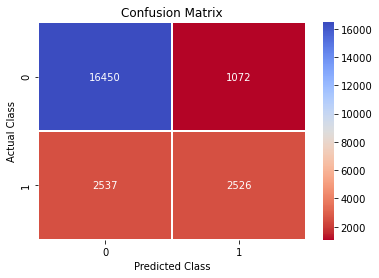

0.5006864877951577

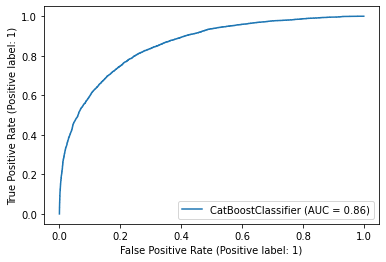

In [60]:
y_pred43 = cat.predict(X_val)
print(classification_report(y_val, y_pred43))

cnf_matrix = confusion_matrix(y_val, y_pred43)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(cat, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred42, average=None) 

## No Scaling <a class="anchor" id="scaling"></a>

In [61]:
df_no_scaling = pd.read_csv("data/weatherAUS.csv")
df_no_scaling.drop(["Sunshine", "Evaporation", "Cloud3pm", "Cloud9am"], axis = 1, inplace = True)
df_no_scaling.dropna(how = 'any', inplace = True)

numerical = list(df_no_scaling._get_numeric_data().columns)
categorical = list(set(df_no_scaling.columns) - set(numerical))

# outliers in numerical columns
for n in numerical:
    q1 = df_no_scaling[n].quantile(0.25)
    q3 = df_no_scaling[n].quantile(0.75)
    IQR = q3 - q1
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR
    df_no_scaling.loc[(df_no_scaling[n] <= lower), n] = lower
    df_no_scaling.loc[(df_no_scaling[n] >= upper), n] = upper  


#### Wind

df_no_scaling = pd.get_dummies(df_no_scaling, columns = ["WindGustDir", "WindDir9am", "WindDir3pm"], drop_first = True)

#### Rain Today / Tomorrow

df_no_scaling["RainToday"] = pd.get_dummies(df_no_scaling["RainToday"], drop_first = True)
df_no_scaling["RainTomorrow"] = pd.get_dummies(df_no_scaling["RainTomorrow"], drop_first = True)

df_no_scaling.drop(["Date", "Location"], axis = 1, inplace = True)


X = df_no_scaling.loc[:,df_no_scaling.columns!='RainTomorrow']
y = df_no_scaling[['RainTomorrow']]

X_train_or, X_test, y_train_or, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size=0.25)

ada = ADASYN()
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

#### Random Forest

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     17619
           1       0.67      0.57      0.62      4966

    accuracy                           0.85     22585
   macro avg       0.78      0.75      0.76     22585
weighted avg       0.84      0.85      0.84     22585



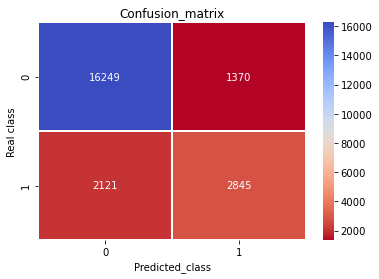

0.7475693618930083

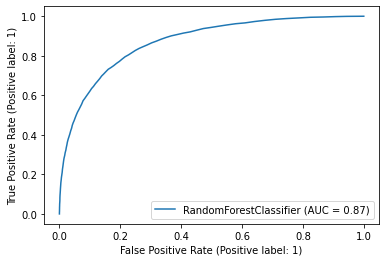

In [62]:
rf=RandomForestClassifier()
rf.fit(X_train_ada, y_train_ada.values.ravel())

y_pred13 = rf.predict(X_val)
print(classification_report(y_val,y_pred13))

cnf_matrix = confusion_matrix(y_val, y_pred13)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5,fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(rf, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred13, average=None)

#### Logistic Regression

              precision    recall  f1-score   support

           0       0.92      0.75      0.83     17619
           1       0.47      0.78      0.58      4966

    accuracy                           0.76     22585
   macro avg       0.69      0.76      0.71     22585
weighted avg       0.82      0.76      0.77     22585



C:\Users\Meshal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


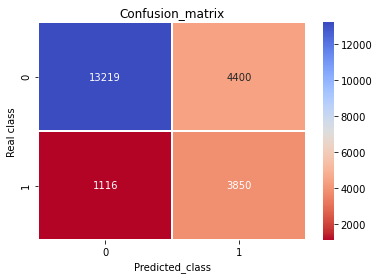

0.7627707219467542

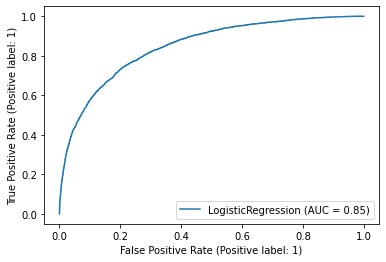

In [63]:
logreg = LogisticRegression()
logreg.fit(X_train_ada, y_train_ada.values.ravel())

y_pred23 = logreg.predict(X_val)
print(classification_report(y_val,y_pred23))

cnf_matrix = confusion_matrix(y_val, y_pred23)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(logreg, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred23, average=None)

#### XGBoost

[17:35:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     17619
           1       0.67      0.55      0.61      4966

    accuracy                           0.84     22585
   macro avg       0.78      0.74      0.75     22585
weighted avg       0.83      0.84      0.84     22585



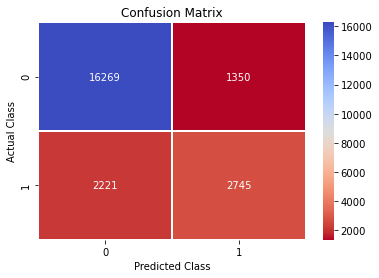

0.7380684654286986

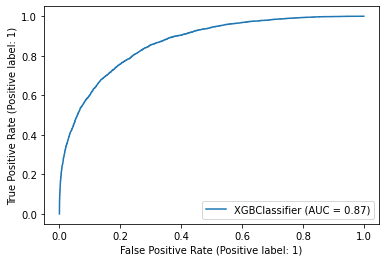

In [64]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train_ada, y_train_ada)

y_pred33 = xgb.predict(X_val)
print(classification_report(y_val,y_pred33))

cnf_matrix = confusion_matrix(y_val, y_pred33)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(xgb, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred33, average=None)

#### CatBoost

In [65]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_ada, y_train_ada)

Learning rate set to 0.039697
0:	total: 21.9ms	remaining: 43.8s
1:	total: 29ms	remaining: 29s
2:	total: 36.3ms	remaining: 24.1s
3:	total: 43.4ms	remaining: 21.7s
4:	total: 51.1ms	remaining: 20.4s
5:	total: 58.2ms	remaining: 19.3s
6:	total: 65ms	remaining: 18.5s
7:	total: 72.5ms	remaining: 18.1s
8:	total: 79.8ms	remaining: 17.7s
9:	total: 86.7ms	remaining: 17.3s
10:	total: 93.3ms	remaining: 16.9s
11:	total: 100ms	remaining: 16.6s
12:	total: 107ms	remaining: 16.3s
13:	total: 113ms	remaining: 16s
14:	total: 119ms	remaining: 15.8s
15:	total: 126ms	remaining: 15.6s
16:	total: 133ms	remaining: 15.5s
17:	total: 140ms	remaining: 15.4s
18:	total: 146ms	remaining: 15.2s
19:	total: 152ms	remaining: 15.1s
20:	total: 159ms	remaining: 15s
21:	total: 165ms	remaining: 14.9s
22:	total: 171ms	remaining: 14.7s
23:	total: 177ms	remaining: 14.6s
24:	total: 184ms	remaining: 14.5s
25:	total: 190ms	remaining: 14.5s
26:	total: 197ms	remaining: 14.4s
27:	total: 203ms	remaining: 14.3s
28:	total: 209ms	remaining:

250:	total: 1.67s	remaining: 11.6s
251:	total: 1.67s	remaining: 11.6s
252:	total: 1.68s	remaining: 11.6s
253:	total: 1.68s	remaining: 11.6s
254:	total: 1.69s	remaining: 11.6s
255:	total: 1.7s	remaining: 11.6s
256:	total: 1.7s	remaining: 11.6s
257:	total: 1.71s	remaining: 11.5s
258:	total: 1.72s	remaining: 11.5s
259:	total: 1.72s	remaining: 11.5s
260:	total: 1.73s	remaining: 11.5s
261:	total: 1.73s	remaining: 11.5s
262:	total: 1.74s	remaining: 11.5s
263:	total: 1.75s	remaining: 11.5s
264:	total: 1.75s	remaining: 11.5s
265:	total: 1.76s	remaining: 11.5s
266:	total: 1.76s	remaining: 11.5s
267:	total: 1.77s	remaining: 11.4s
268:	total: 1.78s	remaining: 11.4s
269:	total: 1.78s	remaining: 11.4s
270:	total: 1.79s	remaining: 11.4s
271:	total: 1.8s	remaining: 11.4s
272:	total: 1.81s	remaining: 11.4s
273:	total: 1.81s	remaining: 11.4s
274:	total: 1.82s	remaining: 11.4s
275:	total: 1.83s	remaining: 11.4s
276:	total: 1.83s	remaining: 11.4s
277:	total: 1.84s	remaining: 11.4s
278:	total: 1.85s	remai

502:	total: 3.53s	remaining: 10.5s
503:	total: 3.53s	remaining: 10.5s
504:	total: 3.54s	remaining: 10.5s
505:	total: 3.55s	remaining: 10.5s
506:	total: 3.55s	remaining: 10.5s
507:	total: 3.56s	remaining: 10.5s
508:	total: 3.56s	remaining: 10.4s
509:	total: 3.57s	remaining: 10.4s
510:	total: 3.58s	remaining: 10.4s
511:	total: 3.58s	remaining: 10.4s
512:	total: 3.59s	remaining: 10.4s
513:	total: 3.6s	remaining: 10.4s
514:	total: 3.6s	remaining: 10.4s
515:	total: 3.61s	remaining: 10.4s
516:	total: 3.62s	remaining: 10.4s
517:	total: 3.62s	remaining: 10.4s
518:	total: 3.63s	remaining: 10.4s
519:	total: 3.64s	remaining: 10.4s
520:	total: 3.64s	remaining: 10.3s
521:	total: 3.65s	remaining: 10.3s
522:	total: 3.66s	remaining: 10.3s
523:	total: 3.66s	remaining: 10.3s
524:	total: 3.67s	remaining: 10.3s
525:	total: 3.67s	remaining: 10.3s
526:	total: 3.68s	remaining: 10.3s
527:	total: 3.69s	remaining: 10.3s
528:	total: 3.69s	remaining: 10.3s
529:	total: 3.7s	remaining: 10.3s
530:	total: 3.71s	remai

740:	total: 5.19s	remaining: 8.81s
741:	total: 5.19s	remaining: 8.8s
742:	total: 5.2s	remaining: 8.8s
743:	total: 5.21s	remaining: 8.79s
744:	total: 5.22s	remaining: 8.79s
745:	total: 5.22s	remaining: 8.78s
746:	total: 5.23s	remaining: 8.77s
747:	total: 5.24s	remaining: 8.77s
748:	total: 5.24s	remaining: 8.76s
749:	total: 5.25s	remaining: 8.75s
750:	total: 5.26s	remaining: 8.74s
751:	total: 5.26s	remaining: 8.74s
752:	total: 5.27s	remaining: 8.73s
753:	total: 5.28s	remaining: 8.72s
754:	total: 5.28s	remaining: 8.71s
755:	total: 5.29s	remaining: 8.71s
756:	total: 5.3s	remaining: 8.7s
757:	total: 5.31s	remaining: 8.69s
758:	total: 5.31s	remaining: 8.69s
759:	total: 5.32s	remaining: 8.68s
760:	total: 5.33s	remaining: 8.67s
761:	total: 5.33s	remaining: 8.67s
762:	total: 5.34s	remaining: 8.66s
763:	total: 5.35s	remaining: 8.65s
764:	total: 5.36s	remaining: 8.65s
765:	total: 5.36s	remaining: 8.64s
766:	total: 5.37s	remaining: 8.63s
767:	total: 5.38s	remaining: 8.62s
768:	total: 5.38s	remaini

983:	total: 6.84s	remaining: 7.06s
984:	total: 6.84s	remaining: 7.05s
985:	total: 6.85s	remaining: 7.04s
986:	total: 6.86s	remaining: 7.04s
987:	total: 6.86s	remaining: 7.03s
988:	total: 6.87s	remaining: 7.02s
989:	total: 6.88s	remaining: 7.01s
990:	total: 6.88s	remaining: 7.01s
991:	total: 6.89s	remaining: 7s
992:	total: 6.9s	remaining: 6.99s
993:	total: 6.9s	remaining: 6.99s
994:	total: 6.91s	remaining: 6.98s
995:	total: 6.92s	remaining: 6.97s
996:	total: 6.92s	remaining: 6.96s
997:	total: 6.93s	remaining: 6.96s
998:	total: 6.94s	remaining: 6.95s
999:	total: 6.94s	remaining: 6.94s
1000:	total: 6.95s	remaining: 6.93s
1001:	total: 6.95s	remaining: 6.93s
1002:	total: 6.96s	remaining: 6.92s
1003:	total: 6.97s	remaining: 6.91s
1004:	total: 6.97s	remaining: 6.91s
1005:	total: 6.98s	remaining: 6.9s
1006:	total: 6.99s	remaining: 6.89s
1007:	total: 6.99s	remaining: 6.88s
1008:	total: 7s	remaining: 6.88s
1009:	total: 7.01s	remaining: 6.87s
1010:	total: 7.01s	remaining: 6.86s
1011:	total: 7.02s

1229:	total: 8.48s	remaining: 5.31s
1230:	total: 8.49s	remaining: 5.3s
1231:	total: 8.5s	remaining: 5.3s
1232:	total: 8.51s	remaining: 5.29s
1233:	total: 8.51s	remaining: 5.28s
1234:	total: 8.52s	remaining: 5.28s
1235:	total: 8.53s	remaining: 5.27s
1236:	total: 8.53s	remaining: 5.26s
1237:	total: 8.54s	remaining: 5.25s
1238:	total: 8.54s	remaining: 5.25s
1239:	total: 8.55s	remaining: 5.24s
1240:	total: 8.56s	remaining: 5.24s
1241:	total: 8.57s	remaining: 5.23s
1242:	total: 8.57s	remaining: 5.22s
1243:	total: 8.58s	remaining: 5.21s
1244:	total: 8.59s	remaining: 5.21s
1245:	total: 8.6s	remaining: 5.2s
1246:	total: 8.6s	remaining: 5.19s
1247:	total: 8.61s	remaining: 5.19s
1248:	total: 8.62s	remaining: 5.18s
1249:	total: 8.62s	remaining: 5.17s
1250:	total: 8.63s	remaining: 5.17s
1251:	total: 8.63s	remaining: 5.16s
1252:	total: 8.64s	remaining: 5.15s
1253:	total: 8.65s	remaining: 5.14s
1254:	total: 8.65s	remaining: 5.14s
1255:	total: 8.66s	remaining: 5.13s
1256:	total: 8.67s	remaining: 5.12

1477:	total: 10.1s	remaining: 3.58s
1478:	total: 10.1s	remaining: 3.57s
1479:	total: 10.1s	remaining: 3.56s
1480:	total: 10.2s	remaining: 3.56s
1481:	total: 10.2s	remaining: 3.55s
1482:	total: 10.2s	remaining: 3.54s
1483:	total: 10.2s	remaining: 3.54s
1484:	total: 10.2s	remaining: 3.53s
1485:	total: 10.2s	remaining: 3.52s
1486:	total: 10.2s	remaining: 3.52s
1487:	total: 10.2s	remaining: 3.51s
1488:	total: 10.2s	remaining: 3.5s
1489:	total: 10.2s	remaining: 3.49s
1490:	total: 10.2s	remaining: 3.49s
1491:	total: 10.2s	remaining: 3.48s
1492:	total: 10.2s	remaining: 3.47s
1493:	total: 10.2s	remaining: 3.46s
1494:	total: 10.2s	remaining: 3.46s
1495:	total: 10.2s	remaining: 3.45s
1496:	total: 10.3s	remaining: 3.44s
1497:	total: 10.3s	remaining: 3.44s
1498:	total: 10.3s	remaining: 3.43s
1499:	total: 10.3s	remaining: 3.42s
1500:	total: 10.3s	remaining: 3.42s
1501:	total: 10.3s	remaining: 3.41s
1502:	total: 10.3s	remaining: 3.4s
1503:	total: 10.3s	remaining: 3.4s
1504:	total: 10.3s	remaining: 3

1727:	total: 11.8s	remaining: 1.85s
1728:	total: 11.8s	remaining: 1.85s
1729:	total: 11.8s	remaining: 1.84s
1730:	total: 11.8s	remaining: 1.83s
1731:	total: 11.8s	remaining: 1.83s
1732:	total: 11.8s	remaining: 1.82s
1733:	total: 11.8s	remaining: 1.81s
1734:	total: 11.8s	remaining: 1.81s
1735:	total: 11.8s	remaining: 1.8s
1736:	total: 11.8s	remaining: 1.79s
1737:	total: 11.8s	remaining: 1.79s
1738:	total: 11.9s	remaining: 1.78s
1739:	total: 11.9s	remaining: 1.77s
1740:	total: 11.9s	remaining: 1.76s
1741:	total: 11.9s	remaining: 1.76s
1742:	total: 11.9s	remaining: 1.75s
1743:	total: 11.9s	remaining: 1.75s
1744:	total: 11.9s	remaining: 1.74s
1745:	total: 11.9s	remaining: 1.73s
1746:	total: 11.9s	remaining: 1.72s
1747:	total: 11.9s	remaining: 1.72s
1748:	total: 11.9s	remaining: 1.71s
1749:	total: 11.9s	remaining: 1.7s
1750:	total: 11.9s	remaining: 1.7s
1751:	total: 11.9s	remaining: 1.69s
1752:	total: 11.9s	remaining: 1.68s
1753:	total: 12s	remaining: 1.68s
1754:	total: 12s	remaining: 1.67s

1972:	total: 13.4s	remaining: 184ms
1973:	total: 13.4s	remaining: 177ms
1974:	total: 13.4s	remaining: 170ms
1975:	total: 13.4s	remaining: 163ms
1976:	total: 13.5s	remaining: 157ms
1977:	total: 13.5s	remaining: 150ms
1978:	total: 13.5s	remaining: 143ms
1979:	total: 13.5s	remaining: 136ms
1980:	total: 13.5s	remaining: 129ms
1981:	total: 13.5s	remaining: 122ms
1982:	total: 13.5s	remaining: 116ms
1983:	total: 13.5s	remaining: 109ms
1984:	total: 13.5s	remaining: 102ms
1985:	total: 13.5s	remaining: 95.2ms
1986:	total: 13.5s	remaining: 88.4ms
1987:	total: 13.5s	remaining: 81.6ms
1988:	total: 13.5s	remaining: 74.8ms
1989:	total: 13.5s	remaining: 68ms
1990:	total: 13.5s	remaining: 61.2ms
1991:	total: 13.6s	remaining: 54.4ms
1992:	total: 13.6s	remaining: 47.6ms
1993:	total: 13.6s	remaining: 40.8ms
1994:	total: 13.6s	remaining: 34ms
1995:	total: 13.6s	remaining: 27.2ms
1996:	total: 13.6s	remaining: 20.4ms
1997:	total: 13.6s	remaining: 13.6ms
1998:	total: 13.6s	remaining: 6.8ms
1999:	total: 13.6s	

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     17619
           1       0.71      0.55      0.62      4966

    accuracy                           0.85     22585
   macro avg       0.79      0.74      0.76     22585
weighted avg       0.84      0.85      0.84     22585



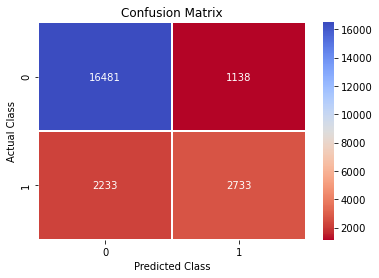

0.4977584334928219

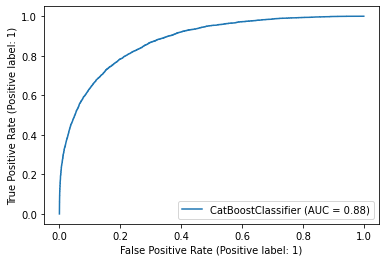

In [66]:
y_pred43 = cat.predict(X_val)
print(classification_report(y_val, y_pred43))

cnf_matrix = confusion_matrix(y_val, y_pred43)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(cat, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred42, average=None) 

## Feature Engineering <a class="anchor" id="engineering"></a>

In [67]:
df_fe = pd.read_csv("data/weatherAUS.csv")
df_fe.drop(["Sunshine", "Evaporation", "Cloud3pm", "Cloud9am"], axis = 1, inplace = True)
df_fe.dropna(how = 'any', inplace = True)

# Feature Engineering
df_fe["AveTemp"] = (df_fe["MinTemp"]+df_fe["MaxTemp"])/2
df_fe["WindSpeed12pm"] = (df_fe["WindSpeed3pm"]+df_fe["WindSpeed9am"])/2
df_fe["Humidity12pm"] = (df_fe["Humidity3pm"]+df_fe["Humidity9am"])/2
df_fe["Pressure12pm"] = (df_fe["Pressure3pm"]+df_fe["Pressure9am"])/2
df_fe["Temp12am"] = (df_fe["Temp3pm"]+df_fe["Temp9am"])/2

numerical = list(df_fe._get_numeric_data().columns)
categorical = list(set(df_fe.columns) - set(numerical))

# outliers in numerical columns
for n in numerical:
    q1 = df_fe[n].quantile(0.25)
    q3 = df_fe[n].quantile(0.75)
    IQR = q3 - q1
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR
    df_fe.loc[(df_fe[n] <= lower), n] = lower
    df_fe.loc[(df_fe[n] >= upper), n] = upper  


#### Wind

df_fe = pd.get_dummies(df_fe, columns = ["WindGustDir", "WindDir9am", "WindDir3pm"], drop_first = True)

#### Rain Today / Tomorrow

df_fe["RainToday"] = pd.get_dummies(df_fe["RainToday"], drop_first = True)
df_fe["RainTomorrow"] = pd.get_dummies(df_fe["RainTomorrow"], drop_first = True)

df_fe.drop(["Date", "Location"], axis = 1, inplace = True)


X = df_fe.loc[:,df_fe.columns!='RainTomorrow']
y = df_fe[['RainTomorrow']]

X_train_or, X_test, y_train_or, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size=0.25)

ada = ADASYN()
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

#### Random Forest

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     17609
           1       0.68      0.59      0.63      4976

    accuracy                           0.85     22585
   macro avg       0.78      0.75      0.77     22585
weighted avg       0.84      0.85      0.84     22585



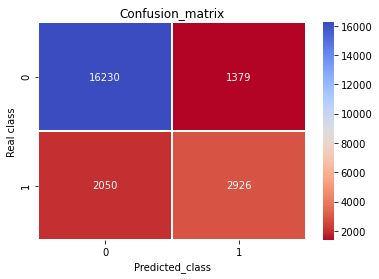

0.7548551406681654

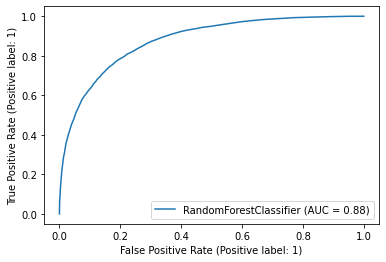

In [68]:
rf=RandomForestClassifier()
rf.fit(X_train_ada, y_train_ada.values.ravel())

y_pred13 = rf.predict(X_val)
print(classification_report(y_val,y_pred13))

cnf_matrix = confusion_matrix(y_val, y_pred13)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5,fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(rf, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred13, average=None)

#### Logistic Regression

              precision    recall  f1-score   support

           0       0.93      0.74      0.82     17609
           1       0.46      0.81      0.59      4976

    accuracy                           0.75     22585
   macro avg       0.70      0.77      0.71     22585
weighted avg       0.83      0.75      0.77     22585



C:\Users\Meshal\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


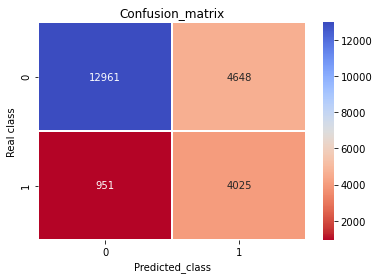

0.7724633525150377

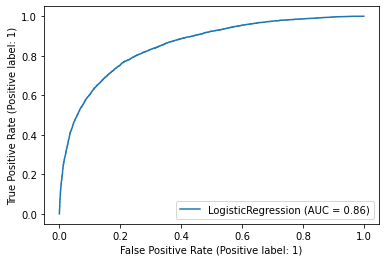

In [69]:
logreg = LogisticRegression()
logreg.fit(X_train_ada, y_train_ada.values.ravel())

y_pred23 = logreg.predict(X_val)
print(classification_report(y_val,y_pred23))

cnf_matrix = confusion_matrix(y_val, y_pred23)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

metrics.plot_roc_curve(logreg, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred23, average=None)

#### XGBoost

[17:36:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     17609
           1       0.67      0.57      0.62      4976

    accuracy                           0.84     22585
   macro avg       0.78      0.75      0.76     22585
weighted avg       0.84      0.84      0.84     22585



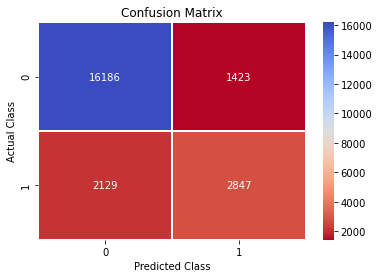

0.7456676766521213

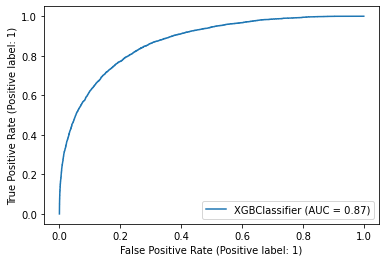

In [70]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train_ada, y_train_ada)

y_pred33 = xgb.predict(X_val)
print(classification_report(y_val,y_pred33))

cnf_matrix = confusion_matrix(y_val, y_pred33)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(xgb, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred33, average=None)

#### CatBoost

In [71]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_ada, y_train_ada)

Learning rate set to 0.039749
0:	total: 9.85ms	remaining: 19.7s
1:	total: 17.8ms	remaining: 17.7s
2:	total: 25.6ms	remaining: 17s
3:	total: 32.8ms	remaining: 16.4s
4:	total: 40.6ms	remaining: 16.2s
5:	total: 48.1ms	remaining: 16s
6:	total: 55.4ms	remaining: 15.8s
7:	total: 62.9ms	remaining: 15.7s
8:	total: 70.2ms	remaining: 15.5s
9:	total: 77.4ms	remaining: 15.4s
10:	total: 85ms	remaining: 15.4s
11:	total: 93.3ms	remaining: 15.5s
12:	total: 101ms	remaining: 15.4s
13:	total: 108ms	remaining: 15.4s
14:	total: 116ms	remaining: 15.3s
15:	total: 123ms	remaining: 15.3s
16:	total: 131ms	remaining: 15.3s
17:	total: 138ms	remaining: 15.2s
18:	total: 146ms	remaining: 15.2s
19:	total: 152ms	remaining: 15.1s
20:	total: 159ms	remaining: 15s
21:	total: 167ms	remaining: 15s
22:	total: 175ms	remaining: 15s
23:	total: 182ms	remaining: 15s
24:	total: 189ms	remaining: 14.9s
25:	total: 196ms	remaining: 14.9s
26:	total: 204ms	remaining: 14.9s
27:	total: 211ms	remaining: 14.9s
28:	total: 218ms	remaining: 14

256:	total: 1.84s	remaining: 12.5s
257:	total: 1.84s	remaining: 12.4s
258:	total: 1.85s	remaining: 12.4s
259:	total: 1.86s	remaining: 12.4s
260:	total: 1.86s	remaining: 12.4s
261:	total: 1.87s	remaining: 12.4s
262:	total: 1.88s	remaining: 12.4s
263:	total: 1.88s	remaining: 12.4s
264:	total: 1.89s	remaining: 12.4s
265:	total: 1.9s	remaining: 12.4s
266:	total: 1.9s	remaining: 12.4s
267:	total: 1.91s	remaining: 12.4s
268:	total: 1.92s	remaining: 12.3s
269:	total: 1.93s	remaining: 12.3s
270:	total: 1.93s	remaining: 12.3s
271:	total: 1.94s	remaining: 12.3s
272:	total: 1.95s	remaining: 12.3s
273:	total: 1.95s	remaining: 12.3s
274:	total: 1.96s	remaining: 12.3s
275:	total: 1.97s	remaining: 12.3s
276:	total: 1.97s	remaining: 12.3s
277:	total: 1.98s	remaining: 12.3s
278:	total: 1.99s	remaining: 12.3s
279:	total: 1.99s	remaining: 12.3s
280:	total: 2s	remaining: 12.2s
281:	total: 2.01s	remaining: 12.2s
282:	total: 2.02s	remaining: 12.2s
283:	total: 2.02s	remaining: 12.2s
284:	total: 2.03s	remaini

509:	total: 3.67s	remaining: 10.7s
510:	total: 3.68s	remaining: 10.7s
511:	total: 3.68s	remaining: 10.7s
512:	total: 3.69s	remaining: 10.7s
513:	total: 3.7s	remaining: 10.7s
514:	total: 3.7s	remaining: 10.7s
515:	total: 3.71s	remaining: 10.7s
516:	total: 3.72s	remaining: 10.7s
517:	total: 3.72s	remaining: 10.7s
518:	total: 3.73s	remaining: 10.6s
519:	total: 3.74s	remaining: 10.6s
520:	total: 3.75s	remaining: 10.6s
521:	total: 3.75s	remaining: 10.6s
522:	total: 3.76s	remaining: 10.6s
523:	total: 3.77s	remaining: 10.6s
524:	total: 3.77s	remaining: 10.6s
525:	total: 3.78s	remaining: 10.6s
526:	total: 3.79s	remaining: 10.6s
527:	total: 3.8s	remaining: 10.6s
528:	total: 3.8s	remaining: 10.6s
529:	total: 3.81s	remaining: 10.6s
530:	total: 3.82s	remaining: 10.6s
531:	total: 3.83s	remaining: 10.6s
532:	total: 3.83s	remaining: 10.6s
533:	total: 3.84s	remaining: 10.5s
534:	total: 3.85s	remaining: 10.5s
535:	total: 3.86s	remaining: 10.5s
536:	total: 3.86s	remaining: 10.5s
537:	total: 3.87s	remain

765:	total: 5.51s	remaining: 8.88s
766:	total: 5.52s	remaining: 8.87s
767:	total: 5.53s	remaining: 8.86s
768:	total: 5.53s	remaining: 8.86s
769:	total: 5.54s	remaining: 8.85s
770:	total: 5.55s	remaining: 8.84s
771:	total: 5.55s	remaining: 8.83s
772:	total: 5.56s	remaining: 8.82s
773:	total: 5.57s	remaining: 8.82s
774:	total: 5.57s	remaining: 8.81s
775:	total: 5.58s	remaining: 8.8s
776:	total: 5.59s	remaining: 8.8s
777:	total: 5.59s	remaining: 8.79s
778:	total: 5.6s	remaining: 8.78s
779:	total: 5.61s	remaining: 8.77s
780:	total: 5.62s	remaining: 8.77s
781:	total: 5.62s	remaining: 8.76s
782:	total: 5.63s	remaining: 8.75s
783:	total: 5.64s	remaining: 8.74s
784:	total: 5.64s	remaining: 8.74s
785:	total: 5.65s	remaining: 8.73s
786:	total: 5.66s	remaining: 8.72s
787:	total: 5.67s	remaining: 8.71s
788:	total: 5.67s	remaining: 8.71s
789:	total: 5.68s	remaining: 8.7s
790:	total: 5.69s	remaining: 8.69s
791:	total: 5.69s	remaining: 8.69s
792:	total: 5.7s	remaining: 8.68s
793:	total: 5.71s	remaini

1026:	total: 7.34s	remaining: 6.96s
1027:	total: 7.35s	remaining: 6.95s
1028:	total: 7.36s	remaining: 6.94s
1029:	total: 7.36s	remaining: 6.93s
1030:	total: 7.37s	remaining: 6.93s
1031:	total: 7.38s	remaining: 6.92s
1032:	total: 7.38s	remaining: 6.91s
1033:	total: 7.39s	remaining: 6.91s
1034:	total: 7.4s	remaining: 6.9s
1035:	total: 7.41s	remaining: 6.89s
1036:	total: 7.41s	remaining: 6.88s
1037:	total: 7.42s	remaining: 6.88s
1038:	total: 7.42s	remaining: 6.87s
1039:	total: 7.43s	remaining: 6.86s
1040:	total: 7.44s	remaining: 6.85s
1041:	total: 7.45s	remaining: 6.85s
1042:	total: 7.45s	remaining: 6.84s
1043:	total: 7.46s	remaining: 6.83s
1044:	total: 7.47s	remaining: 6.82s
1045:	total: 7.47s	remaining: 6.82s
1046:	total: 7.48s	remaining: 6.81s
1047:	total: 7.49s	remaining: 6.8s
1048:	total: 7.5s	remaining: 6.79s
1049:	total: 7.5s	remaining: 6.79s
1050:	total: 7.51s	remaining: 6.78s
1051:	total: 7.52s	remaining: 6.77s
1052:	total: 7.52s	remaining: 6.77s
1053:	total: 7.53s	remaining: 6.7

1261:	total: 8.99s	remaining: 5.26s
1262:	total: 9s	remaining: 5.25s
1263:	total: 9.01s	remaining: 5.24s
1264:	total: 9.01s	remaining: 5.24s
1265:	total: 9.02s	remaining: 5.23s
1266:	total: 9.03s	remaining: 5.22s
1267:	total: 9.04s	remaining: 5.21s
1268:	total: 9.04s	remaining: 5.21s
1269:	total: 9.05s	remaining: 5.2s
1270:	total: 9.06s	remaining: 5.19s
1271:	total: 9.06s	remaining: 5.19s
1272:	total: 9.07s	remaining: 5.18s
1273:	total: 9.08s	remaining: 5.17s
1274:	total: 9.08s	remaining: 5.17s
1275:	total: 9.09s	remaining: 5.16s
1276:	total: 9.1s	remaining: 5.15s
1277:	total: 9.11s	remaining: 5.14s
1278:	total: 9.11s	remaining: 5.14s
1279:	total: 9.12s	remaining: 5.13s
1280:	total: 9.13s	remaining: 5.12s
1281:	total: 9.13s	remaining: 5.12s
1282:	total: 9.14s	remaining: 5.11s
1283:	total: 9.15s	remaining: 5.1s
1284:	total: 9.16s	remaining: 5.09s
1285:	total: 9.16s	remaining: 5.09s
1286:	total: 9.17s	remaining: 5.08s
1287:	total: 9.18s	remaining: 5.07s
1288:	total: 9.18s	remaining: 5.07

1496:	total: 10.6s	remaining: 3.58s
1497:	total: 10.7s	remaining: 3.57s
1498:	total: 10.7s	remaining: 3.56s
1499:	total: 10.7s	remaining: 3.56s
1500:	total: 10.7s	remaining: 3.55s
1501:	total: 10.7s	remaining: 3.54s
1502:	total: 10.7s	remaining: 3.53s
1503:	total: 10.7s	remaining: 3.53s
1504:	total: 10.7s	remaining: 3.52s
1505:	total: 10.7s	remaining: 3.51s
1506:	total: 10.7s	remaining: 3.51s
1507:	total: 10.7s	remaining: 3.5s
1508:	total: 10.7s	remaining: 3.49s
1509:	total: 10.7s	remaining: 3.48s
1510:	total: 10.7s	remaining: 3.48s
1511:	total: 10.8s	remaining: 3.47s
1512:	total: 10.8s	remaining: 3.46s
1513:	total: 10.8s	remaining: 3.46s
1514:	total: 10.8s	remaining: 3.45s
1515:	total: 10.8s	remaining: 3.44s
1516:	total: 10.8s	remaining: 3.44s
1517:	total: 10.8s	remaining: 3.43s
1518:	total: 10.8s	remaining: 3.42s
1519:	total: 10.8s	remaining: 3.41s
1520:	total: 10.8s	remaining: 3.41s
1521:	total: 10.8s	remaining: 3.4s
1522:	total: 10.8s	remaining: 3.39s
1523:	total: 10.8s	remaining: 

1729:	total: 12.3s	remaining: 1.92s
1730:	total: 12.3s	remaining: 1.91s
1731:	total: 12.3s	remaining: 1.91s
1732:	total: 12.3s	remaining: 1.9s
1733:	total: 12.3s	remaining: 1.89s
1734:	total: 12.3s	remaining: 1.89s
1735:	total: 12.4s	remaining: 1.88s
1736:	total: 12.4s	remaining: 1.87s
1737:	total: 12.4s	remaining: 1.86s
1738:	total: 12.4s	remaining: 1.86s
1739:	total: 12.4s	remaining: 1.85s
1740:	total: 12.4s	remaining: 1.84s
1741:	total: 12.4s	remaining: 1.84s
1742:	total: 12.4s	remaining: 1.83s
1743:	total: 12.4s	remaining: 1.82s
1744:	total: 12.4s	remaining: 1.81s
1745:	total: 12.4s	remaining: 1.81s
1746:	total: 12.4s	remaining: 1.8s
1747:	total: 12.4s	remaining: 1.79s
1748:	total: 12.4s	remaining: 1.79s
1749:	total: 12.5s	remaining: 1.78s
1750:	total: 12.5s	remaining: 1.77s
1751:	total: 12.5s	remaining: 1.76s
1752:	total: 12.5s	remaining: 1.76s
1753:	total: 12.5s	remaining: 1.75s
1754:	total: 12.5s	remaining: 1.74s
1755:	total: 12.5s	remaining: 1.74s
1756:	total: 12.5s	remaining: 

1960:	total: 14s	remaining: 278ms
1961:	total: 14s	remaining: 271ms
1962:	total: 14s	remaining: 263ms
1963:	total: 14s	remaining: 256ms
1964:	total: 14s	remaining: 249ms
1965:	total: 14s	remaining: 242ms
1966:	total: 14s	remaining: 235ms
1967:	total: 14s	remaining: 228ms
1968:	total: 14s	remaining: 221ms
1969:	total: 14s	remaining: 214ms
1970:	total: 14s	remaining: 206ms
1971:	total: 14s	remaining: 199ms
1972:	total: 14s	remaining: 192ms
1973:	total: 14.1s	remaining: 185ms
1974:	total: 14.1s	remaining: 178ms
1975:	total: 14.1s	remaining: 171ms
1976:	total: 14.1s	remaining: 164ms
1977:	total: 14.1s	remaining: 157ms
1978:	total: 14.1s	remaining: 149ms
1979:	total: 14.1s	remaining: 142ms
1980:	total: 14.1s	remaining: 135ms
1981:	total: 14.1s	remaining: 128ms
1982:	total: 14.1s	remaining: 121ms
1983:	total: 14.1s	remaining: 114ms
1984:	total: 14.1s	remaining: 107ms
1985:	total: 14.1s	remaining: 99.6ms
1986:	total: 14.1s	remaining: 92.5ms
1987:	total: 14.1s	remaining: 85.4ms
1988:	total: 14

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     17609
           1       0.70      0.57      0.63      4976

    accuracy                           0.85     22585
   macro avg       0.79      0.75      0.77     22585
weighted avg       0.84      0.85      0.85     22585



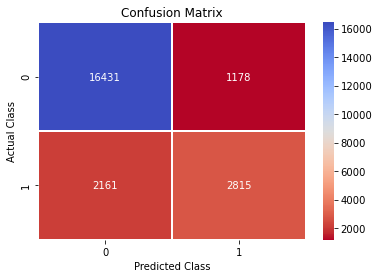

0.5024432341398062

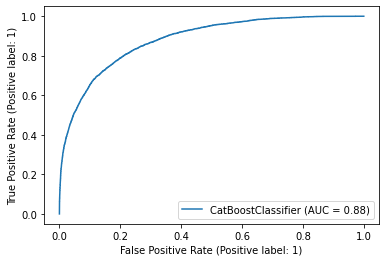

In [72]:
y_pred43 = cat.predict(X_val)
print(classification_report(y_val, y_pred43))

cnf_matrix = confusion_matrix(y_val, y_pred43)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(cat, X_val, y_val)
metrics.roc_auc_score(y_val, y_pred42, average=None) 

# Final Model <a class="anchor" id="final"></a>

### Note: The final model 


In [73]:
X_train_val = pd.concat([X_train_OG, X_val_OG])
y_train_val = pd.concat([y_train_OG, y_val_OG])

cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_val, y_train_val)

Learning rate set to 0.043501
0:	total: 28.4ms	remaining: 56.8s
1:	total: 41.3ms	remaining: 41.3s
2:	total: 55.1ms	remaining: 36.7s
3:	total: 69.2ms	remaining: 34.5s
4:	total: 83.6ms	remaining: 33.3s
5:	total: 96.6ms	remaining: 32.1s
6:	total: 111ms	remaining: 31.5s
7:	total: 122ms	remaining: 30.5s
8:	total: 135ms	remaining: 29.9s
9:	total: 147ms	remaining: 29.3s
10:	total: 159ms	remaining: 28.8s
11:	total: 172ms	remaining: 28.5s
12:	total: 184ms	remaining: 28.2s
13:	total: 198ms	remaining: 28s
14:	total: 209ms	remaining: 27.7s
15:	total: 221ms	remaining: 27.5s
16:	total: 233ms	remaining: 27.2s
17:	total: 245ms	remaining: 27s
18:	total: 257ms	remaining: 26.8s
19:	total: 269ms	remaining: 26.6s
20:	total: 281ms	remaining: 26.5s
21:	total: 293ms	remaining: 26.4s
22:	total: 306ms	remaining: 26.3s
23:	total: 318ms	remaining: 26.2s
24:	total: 331ms	remaining: 26.1s
25:	total: 343ms	remaining: 26s
26:	total: 355ms	remaining: 26s
27:	total: 367ms	remaining: 25.9s
28:	total: 379ms	remaining: 25

239:	total: 3.21s	remaining: 23.6s
240:	total: 3.23s	remaining: 23.5s
241:	total: 3.24s	remaining: 23.5s
242:	total: 3.25s	remaining: 23.5s
243:	total: 3.27s	remaining: 23.5s
244:	total: 3.29s	remaining: 23.5s
245:	total: 3.3s	remaining: 23.5s
246:	total: 3.31s	remaining: 23.5s
247:	total: 3.33s	remaining: 23.5s
248:	total: 3.34s	remaining: 23.5s
249:	total: 3.36s	remaining: 23.5s
250:	total: 3.38s	remaining: 23.5s
251:	total: 3.39s	remaining: 23.5s
252:	total: 3.41s	remaining: 23.5s
253:	total: 3.42s	remaining: 23.5s
254:	total: 3.44s	remaining: 23.5s
255:	total: 3.45s	remaining: 23.5s
256:	total: 3.46s	remaining: 23.5s
257:	total: 3.48s	remaining: 23.5s
258:	total: 3.49s	remaining: 23.5s
259:	total: 3.51s	remaining: 23.5s
260:	total: 3.52s	remaining: 23.5s
261:	total: 3.54s	remaining: 23.5s
262:	total: 3.55s	remaining: 23.5s
263:	total: 3.56s	remaining: 23.4s
264:	total: 3.58s	remaining: 23.5s
265:	total: 3.6s	remaining: 23.4s
266:	total: 3.61s	remaining: 23.4s
267:	total: 3.63s	rema

477:	total: 6.18s	remaining: 19.7s
478:	total: 6.2s	remaining: 19.7s
479:	total: 6.21s	remaining: 19.7s
480:	total: 6.22s	remaining: 19.7s
481:	total: 6.24s	remaining: 19.7s
482:	total: 6.25s	remaining: 19.6s
483:	total: 6.27s	remaining: 19.6s
484:	total: 6.28s	remaining: 19.6s
485:	total: 6.29s	remaining: 19.6s
486:	total: 6.31s	remaining: 19.6s
487:	total: 6.32s	remaining: 19.6s
488:	total: 6.34s	remaining: 19.6s
489:	total: 6.35s	remaining: 19.6s
490:	total: 6.37s	remaining: 19.6s
491:	total: 6.38s	remaining: 19.6s
492:	total: 6.4s	remaining: 19.6s
493:	total: 6.41s	remaining: 19.5s
494:	total: 6.42s	remaining: 19.5s
495:	total: 6.44s	remaining: 19.5s
496:	total: 6.46s	remaining: 19.5s
497:	total: 6.47s	remaining: 19.5s
498:	total: 6.49s	remaining: 19.5s
499:	total: 6.5s	remaining: 19.5s
500:	total: 6.52s	remaining: 19.5s
501:	total: 6.53s	remaining: 19.5s
502:	total: 6.54s	remaining: 19.5s
503:	total: 6.56s	remaining: 19.5s
504:	total: 6.57s	remaining: 19.5s
505:	total: 6.59s	remai

715:	total: 9.17s	remaining: 16.5s
716:	total: 9.19s	remaining: 16.4s
717:	total: 9.2s	remaining: 16.4s
718:	total: 9.21s	remaining: 16.4s
719:	total: 9.22s	remaining: 16.4s
720:	total: 9.23s	remaining: 16.4s
721:	total: 9.25s	remaining: 16.4s
722:	total: 9.26s	remaining: 16.4s
723:	total: 9.27s	remaining: 16.3s
724:	total: 9.28s	remaining: 16.3s
725:	total: 9.29s	remaining: 16.3s
726:	total: 9.31s	remaining: 16.3s
727:	total: 9.32s	remaining: 16.3s
728:	total: 9.33s	remaining: 16.3s
729:	total: 9.35s	remaining: 16.3s
730:	total: 9.36s	remaining: 16.2s
731:	total: 9.37s	remaining: 16.2s
732:	total: 9.39s	remaining: 16.2s
733:	total: 9.4s	remaining: 16.2s
734:	total: 9.41s	remaining: 16.2s
735:	total: 9.43s	remaining: 16.2s
736:	total: 9.44s	remaining: 16.2s
737:	total: 9.45s	remaining: 16.2s
738:	total: 9.46s	remaining: 16.1s
739:	total: 9.48s	remaining: 16.1s
740:	total: 9.49s	remaining: 16.1s
741:	total: 9.5s	remaining: 16.1s
742:	total: 9.51s	remaining: 16.1s
743:	total: 9.52s	remai

963:	total: 12.1s	remaining: 13s
964:	total: 12.1s	remaining: 13s
965:	total: 12.1s	remaining: 13s
966:	total: 12.1s	remaining: 13s
967:	total: 12.1s	remaining: 12.9s
968:	total: 12.2s	remaining: 12.9s
969:	total: 12.2s	remaining: 12.9s
970:	total: 12.2s	remaining: 12.9s
971:	total: 12.2s	remaining: 12.9s
972:	total: 12.2s	remaining: 12.9s
973:	total: 12.2s	remaining: 12.9s
974:	total: 12.2s	remaining: 12.8s
975:	total: 12.2s	remaining: 12.8s
976:	total: 12.2s	remaining: 12.8s
977:	total: 12.3s	remaining: 12.8s
978:	total: 12.3s	remaining: 12.8s
979:	total: 12.3s	remaining: 12.8s
980:	total: 12.3s	remaining: 12.8s
981:	total: 12.3s	remaining: 12.8s
982:	total: 12.3s	remaining: 12.7s
983:	total: 12.3s	remaining: 12.7s
984:	total: 12.3s	remaining: 12.7s
985:	total: 12.4s	remaining: 12.7s
986:	total: 12.4s	remaining: 12.7s
987:	total: 12.4s	remaining: 12.7s
988:	total: 12.4s	remaining: 12.7s
989:	total: 12.4s	remaining: 12.7s
990:	total: 12.4s	remaining: 12.7s
991:	total: 12.4s	remaining:

1204:	total: 15s	remaining: 9.89s
1205:	total: 15s	remaining: 9.88s
1206:	total: 15s	remaining: 9.86s
1207:	total: 15s	remaining: 9.85s
1208:	total: 15s	remaining: 9.84s
1209:	total: 15s	remaining: 9.82s
1210:	total: 15.1s	remaining: 9.81s
1211:	total: 15.1s	remaining: 9.79s
1212:	total: 15.1s	remaining: 9.78s
1213:	total: 15.1s	remaining: 9.77s
1214:	total: 15.1s	remaining: 9.76s
1215:	total: 15.1s	remaining: 9.74s
1216:	total: 15.1s	remaining: 9.73s
1217:	total: 15.1s	remaining: 9.72s
1218:	total: 15.1s	remaining: 9.71s
1219:	total: 15.2s	remaining: 9.69s
1220:	total: 15.2s	remaining: 9.68s
1221:	total: 15.2s	remaining: 9.67s
1222:	total: 15.2s	remaining: 9.66s
1223:	total: 15.2s	remaining: 9.64s
1224:	total: 15.2s	remaining: 9.63s
1225:	total: 15.2s	remaining: 9.62s
1226:	total: 15.2s	remaining: 9.6s
1227:	total: 15.3s	remaining: 9.59s
1228:	total: 15.3s	remaining: 9.58s
1229:	total: 15.3s	remaining: 9.57s
1230:	total: 15.3s	remaining: 9.55s
1231:	total: 15.3s	remaining: 9.54s
1232:

1451:	total: 17.9s	remaining: 6.75s
1452:	total: 17.9s	remaining: 6.74s
1453:	total: 17.9s	remaining: 6.73s
1454:	total: 17.9s	remaining: 6.72s
1455:	total: 17.9s	remaining: 6.71s
1456:	total: 18s	remaining: 6.69s
1457:	total: 18s	remaining: 6.68s
1458:	total: 18s	remaining: 6.67s
1459:	total: 18s	remaining: 6.66s
1460:	total: 18s	remaining: 6.64s
1461:	total: 18s	remaining: 6.63s
1462:	total: 18s	remaining: 6.62s
1463:	total: 18s	remaining: 6.61s
1464:	total: 18.1s	remaining: 6.59s
1465:	total: 18.1s	remaining: 6.58s
1466:	total: 18.1s	remaining: 6.57s
1467:	total: 18.1s	remaining: 6.56s
1468:	total: 18.1s	remaining: 6.54s
1469:	total: 18.1s	remaining: 6.53s
1470:	total: 18.1s	remaining: 6.52s
1471:	total: 18.1s	remaining: 6.5s
1472:	total: 18.1s	remaining: 6.49s
1473:	total: 18.2s	remaining: 6.48s
1474:	total: 18.2s	remaining: 6.47s
1475:	total: 18.2s	remaining: 6.45s
1476:	total: 18.2s	remaining: 6.44s
1477:	total: 18.2s	remaining: 6.43s
1478:	total: 18.2s	remaining: 6.42s
1479:	tot

1684:	total: 20.6s	remaining: 3.85s
1685:	total: 20.6s	remaining: 3.84s
1686:	total: 20.6s	remaining: 3.83s
1687:	total: 20.7s	remaining: 3.82s
1688:	total: 20.7s	remaining: 3.81s
1689:	total: 20.7s	remaining: 3.79s
1690:	total: 20.7s	remaining: 3.78s
1691:	total: 20.7s	remaining: 3.77s
1692:	total: 20.7s	remaining: 3.76s
1693:	total: 20.7s	remaining: 3.74s
1694:	total: 20.7s	remaining: 3.73s
1695:	total: 20.8s	remaining: 3.72s
1696:	total: 20.8s	remaining: 3.71s
1697:	total: 20.8s	remaining: 3.69s
1698:	total: 20.8s	remaining: 3.68s
1699:	total: 20.8s	remaining: 3.67s
1700:	total: 20.8s	remaining: 3.66s
1701:	total: 20.8s	remaining: 3.65s
1702:	total: 20.8s	remaining: 3.63s
1703:	total: 20.8s	remaining: 3.62s
1704:	total: 20.9s	remaining: 3.61s
1705:	total: 20.9s	remaining: 3.6s
1706:	total: 20.9s	remaining: 3.58s
1707:	total: 20.9s	remaining: 3.57s
1708:	total: 20.9s	remaining: 3.56s
1709:	total: 20.9s	remaining: 3.55s
1710:	total: 20.9s	remaining: 3.54s
1711:	total: 20.9s	remaining:

1914:	total: 23.4s	remaining: 1.04s
1915:	total: 23.4s	remaining: 1.02s
1916:	total: 23.4s	remaining: 1.01s
1917:	total: 23.4s	remaining: 1000ms
1918:	total: 23.4s	remaining: 988ms
1919:	total: 23.4s	remaining: 975ms
1920:	total: 23.4s	remaining: 963ms
1921:	total: 23.4s	remaining: 951ms
1922:	total: 23.4s	remaining: 939ms
1923:	total: 23.5s	remaining: 926ms
1924:	total: 23.5s	remaining: 914ms
1925:	total: 23.5s	remaining: 902ms
1926:	total: 23.5s	remaining: 890ms
1927:	total: 23.5s	remaining: 877ms
1928:	total: 23.5s	remaining: 865ms
1929:	total: 23.5s	remaining: 853ms
1930:	total: 23.5s	remaining: 841ms
1931:	total: 23.5s	remaining: 829ms
1932:	total: 23.6s	remaining: 816ms
1933:	total: 23.6s	remaining: 804ms
1934:	total: 23.6s	remaining: 792ms
1935:	total: 23.6s	remaining: 780ms
1936:	total: 23.6s	remaining: 768ms
1937:	total: 23.6s	remaining: 755ms
1938:	total: 23.6s	remaining: 743ms
1939:	total: 23.6s	remaining: 731ms
1940:	total: 23.6s	remaining: 719ms
1941:	total: 23.7s	remainin

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93     17534
         1.0       0.82      0.63      0.71      5051

    accuracy                           0.89     22585
   macro avg       0.86      0.80      0.82     22585
weighted avg       0.88      0.89      0.88     22585



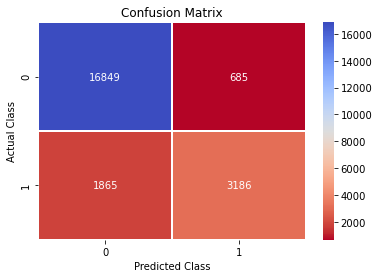

0.7958496146424074

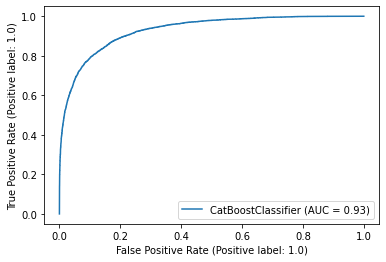

In [74]:
y_pred = cat.predict(X_val_OG)
print(classification_report(y_val_OG, y_pred))

cnf_matrix = confusion_matrix(y_val_OG, y_pred)
sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

metrics.plot_roc_curve(cat, X_val_OG, y_val_OG)
metrics.roc_auc_score(y_val_OG, y_pred, average=None) 

## Saving The Model

In [83]:
# save the model
file = open('catboost_rain_prediction.pkl', 'wb')
pkl.dump(cat, file)